### Imports

In [23]:
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import statistics
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
from IPython.display import display

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from ucimlrepo import fetch_ucirepo 

### Distância de Minkowski

In [24]:
def calculateDist(p1, p2, n):
    return ((abs(p1[0] - p2[0])**n) + (abs(p1[1] - p2[1])**n)) ** (1/n)

* __Distância Manhattan__ __->__  n = 1

* __Distância Euclidiana__ __->__  n = 2


In [25]:
# Cálculo da matriz de distâncias entre os pontos do dataset
def calculateDistances(pontos, n):
    distances = [[] for _ in range(len(pontos))]
    for i, p1 in enumerate(pontos):
        for j, p2 in enumerate(pontos):
            distances[i].append(calculateDist(p1, p2, n))
    return distances

### Função para vizualização

In [26]:
def plotClusters2D(clusters,n):
    
    plt.figure(figsize=(8, 8))
    colors = plt.get_cmap('Set1', len(clusters))  
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i + 1}')
        
        #Centro do cluster
        center = np.array(cluster[0])
        plt.scatter(center[0], center[1], color='black', marker='x')
        
        #Raio
        max_dist = max([calculateDist(center,p,n) for p in cluster])
        circle = plt.Circle(center, max_dist, color=colors(i), fill=False, linestyle='--')
        plt.gca().add_patch(circle)
        plt.text(center[0], center[1] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Clusters')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


### Funções auxiliares 

In [28]:
# Visualização das informações dos clusters gerados
def printClusters(clusters,n):
    
    print(f"Clusters encontrados: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}:")
        print(f"Pontos: {cluster}")
        max_dist = max([calculateDist(cluster[0], p,2) for p in cluster])
        print(f"Raio do Cluster: {max_dist}")

In [29]:
def get_labels(clusters, pontos):
    labels = [-1] * len(pontos) 
    point_to_label = {}

    for cluster_index, cluster in enumerate(clusters):
        for point in cluster:
            point_to_label[tuple(point)] = cluster_index

    for i, point in enumerate(pontos):
        labels[i] = point_to_label[tuple(point)]
        
    return labels

### Primeira versão do algoritmo 2-aproximado

Nessa versão  o intervalo para o raio ótimo é refinado até uma largura definida. Primeiramente vamos definir funções auxiliares para conseguir fazer o algoritmo:

In [30]:
# Função responsável por determinar se é possível dado um conjunto de pontos achar k clusters de raio maximo 2 rmax

def findSolution(pontos, rmax, k,n):
    success = False
    solution = []
    clusters = []
    pts = pontos[:]
    
    while len(pts) > 0:
        current_p = pts.pop(0)
        solution.append(current_p)
        cluster = [current_p]
        
        pts_to_remove = []
        for p in pts:
            if calculateDist(current_p, p, n) < 2 * rmax:
                cluster.append(p)
                pts_to_remove.append(p)
        
        for p in pts_to_remove:
            pts.remove(p)
        
        clusters.append(cluster)
    
    if len(solution) <= k:
        success = True
    
    return success, clusters


Agora podemos ir para a implementação do algoritmo em si:

In [31]:
def k_clustering(pontos,porcentagem_largura,k_clusters,n_distancia,distMatrix,true_labels):
    limite_superior = max(max(row) for row in distMatrix)
    limite_inferior = 0
    
    largura_total = limite_superior - limite_inferior 
    
    raio = limite_superior/2
    
    success = False
    
    while not(success) or ((limite_superior-limite_inferior) >= (porcentagem_largura*largura_total)):
        success, clusters = findSolution(pontos, raio, k_clusters,n_distancia)
        if success:
            limite_superior = raio
            raio = limite_superior/2
        else:
            limite_inferior = raio
            raio = raio + raio/2
    
            
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)
    
    labels = get_labels(clusters, pontos)
        
    if len(set(labels)) > 1:  # Verifica se há mais de um cluster
        sil_score = silhouette_score(pontos, labels)
    else:
        sil_score = 0  # Define como 0 ou outro valor padrão quando há apenas um cluster
    
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari
    

### Segunda versão do algoritmo 2-aproximado

Os centros são escolhidos para maximizar a distância entre os centros previamente escolhidos

In [32]:
# Calcula o ponto com a máxima distância mínima aos pontos em centers
def mostDistant(pontos, centers, n, distMatrix):
    maxDist = 0
    for p in pontos:
        if p not in centers:
            minDist = np.inf
            for c in centers:
                dist = distMatrix[pontos.index(p)][pontos.index(c)]
                if dist < minDist:
                    minDist = dist
            if minDist > maxDist:
                maxDist = minDist
                p_choice = p
    return p_choice

# Determina os centros dos clusters
def getCenters(pontos,k_clusters,n,distMatrix):
    if k_clusters >= len(pontos):
        return pontos
    
    centers = [pontos[0]]
    while (len(centers) < k_clusters):
        s = mostDistant(pontos, centers, n, distMatrix)
        centers.append(s)
    return centers

# Determina o centro mais próximo do ponto p
def find_closest_center(pontos, centers, p, n, distMatrix):
    minDist = np.inf
    for c in centers:
        dist = distMatrix[pontos.index(p)][pontos.index(c)]
        if dist < minDist:
            minDist = dist
            closest_center = c
    return closest_center

# Determina os clusters por meio da maximização dos centros já escolhidos
def makeClusters(pontos, k_clusters, n, distMatrix, true_labels):
    centers = getCenters(pontos, k_clusters, n, distMatrix)
    clusters = [[c] for c in centers] # inicializa os clusters apenas com o centro
    for p in pontos:
        closest_center = find_closest_center(pontos, centers, p, n, distMatrix)
        clusters[centers.index(closest_center)].append(p)
    # calcula o raio de cada cluster
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)

    labels = get_labels(clusters, pontos)
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari


### Kmeans

In [33]:
def performKmeans(pontos, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(pontos)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(labels):
        clusters[label].append(pontos[i])

    for i in range(n_clusters):
        clusters[i] = np.array(clusters[i])
    
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)

    radii = []
    centroids = kmeans.cluster_centers_
    for i in range(kmeans.n_clusters):
        cluster_points = clusters[i]
        
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        
        radius = np.max(distances)
        radii.append(radius)

    return clusters, radii, sil_score, ari


## Dados

### Carregamento dos dados reais

Arquivos obtidos após pré-processamento.
As IDs dos dados no site https://archive.ics.uci.edu/ são as seguintes: 

hepatitis: 503 <br>
raisin: 850 <br>
mice_protein: 342 <br>
yeast: 110 <br>
maternal_risk: 863 <br>
credit: 144 <br>
adult: 2 <br>
diabetic_retinopathy: 329 <br>
dry_beans: 602 <br>
wine_quality: 186 <br>

In [34]:
df_hepatitis = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/hepatitis.csv')
df_raisin = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/raisin.csv')
df_mice_protein = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/mice_protein.csv')
df_yeast = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/yeast.csv')
df_maternal_risk = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/maternal_risk.csv')
df_credit = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/credit.csv')
df_adult = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/adult.csv')
df_diabetic_retinopathy = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/diabetic_retinopathy.csv')
df_dry_beans = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/dry_beans.csv')
df_wine_quality = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/wine_quality.csv')

real_datasets = [df_hepatitis, df_raisin, df_mice_protein, df_yeast, df_maternal_risk, df_credit, df_adult, df_diabetic_retinopathy, df_dry_beans, df_wine_quality]

In [35]:
from os import name
labels_list_real = [[] for _ in range(10)]
dada_real = [[] for _ in range(10)]
qt_clusters_real = []
for i, df in enumerate(real_datasets):
    labels_list_real[i].append(df['Label'].values)
    dada_real[i].append(df[df.columns[:-1]].values)
    qt_clusters_real.append(len(df['Label'].unique()))


names_models_real = ['hepatitis', 'raisin', 'mice_protein', 'yeast', 'maternal_risk', 'credit', 'adult', 'diabetic_retinopathy', 'dry_beans','wine_quality']

### Geração de datasets sintéticos

##### Normal multivariada

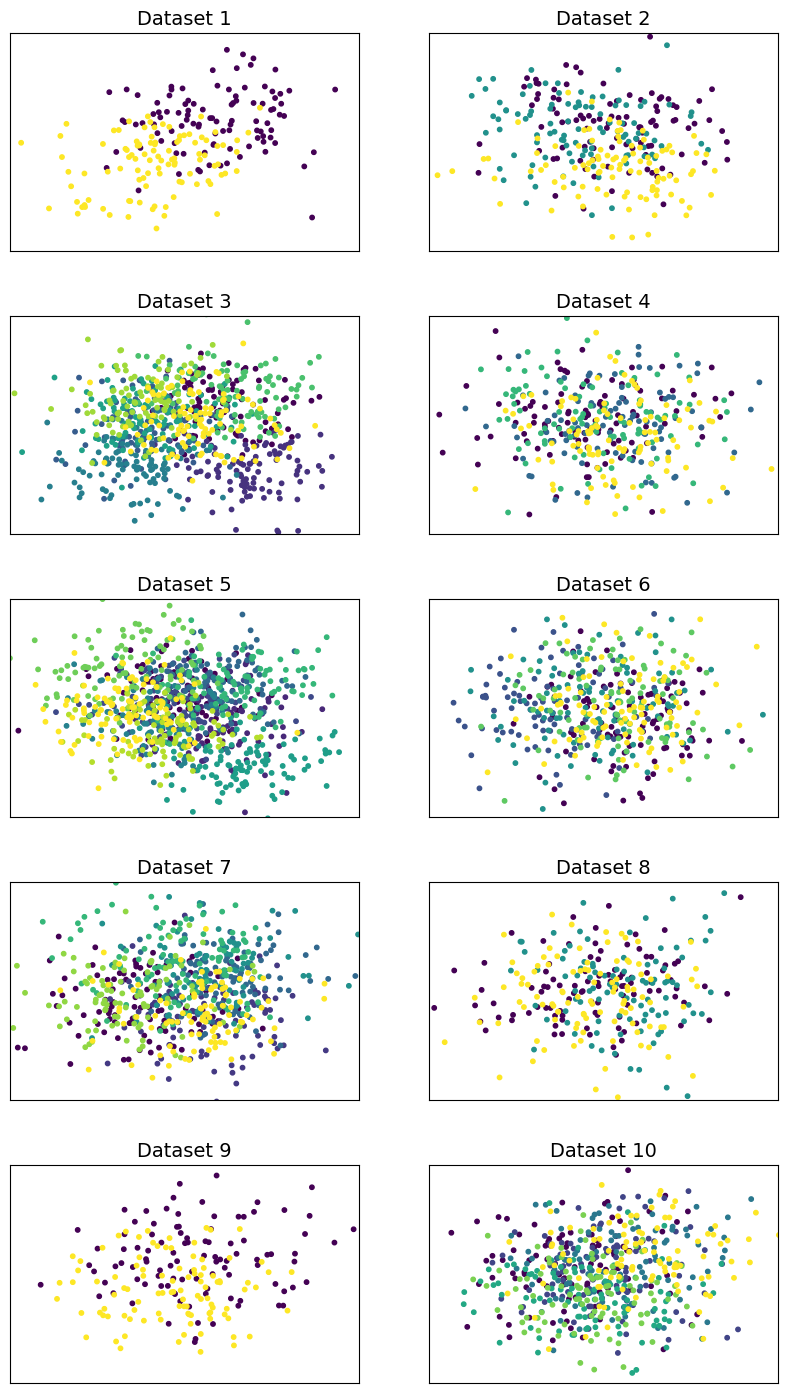

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def generate_random_coordinates(x):
    coordinates = np.random.rand(x, 2)
    return coordinates

def generateSyntheticDataWithLabels(centers, std_dev, num_points_per_center):
    pontos = []
    labels = []
    
    for idx, center in enumerate(centers):
        cov_matrix = [[std_dev**2, 0], [0, std_dev**2]]
        points = np.random.multivariate_normal(mean=center, cov=cov_matrix, size=num_points_per_center)
        pontos.append(points)
        labels.extend([idx] * num_points_per_center)  
    
    return np.vstack(pontos), np.array(labels)

def apply_standard_scaling(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

n_clusters_normal = [2, 3, 8, 4, 10, 5, 7, 3, 2, 6]  # Número de clusters variado
std_devs = [0.1, 0.5, 0.3, 1.0, 0.2, 0.7, 0.4, 1.5, 0.6, 0.9]  # Desvios padrão variáveis

base_num_points = 100
num_points_per_center = [int(base_num_points) for std_dev in std_devs]

data_normal = []
labels_list_normal = []
for i in range(10):
    centers = generate_random_coordinates(n_clusters_normal[i])
    dataset, labels = generateSyntheticDataWithLabels(centers, std_devs[i], num_points_per_center[i])
    scaled_dataset = apply_standard_scaling(dataset)
    data_normal.append(scaled_dataset)
    labels_list_normal.append(labels)

# Plotting
n_rows = 5
n_cols = 2
plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.92, wspace=0.2, hspace=0.3)

for i in range(10):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(f"Dataset {i+1}", size=14)
    plt.scatter(data_normal[i][:, 0], data_normal[i][:, 1], c=labels_list_normal[i], s=10, cmap='viridis')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xticks(())
    plt.yticks(())

plt.show()

##### Exemplos scikit learn

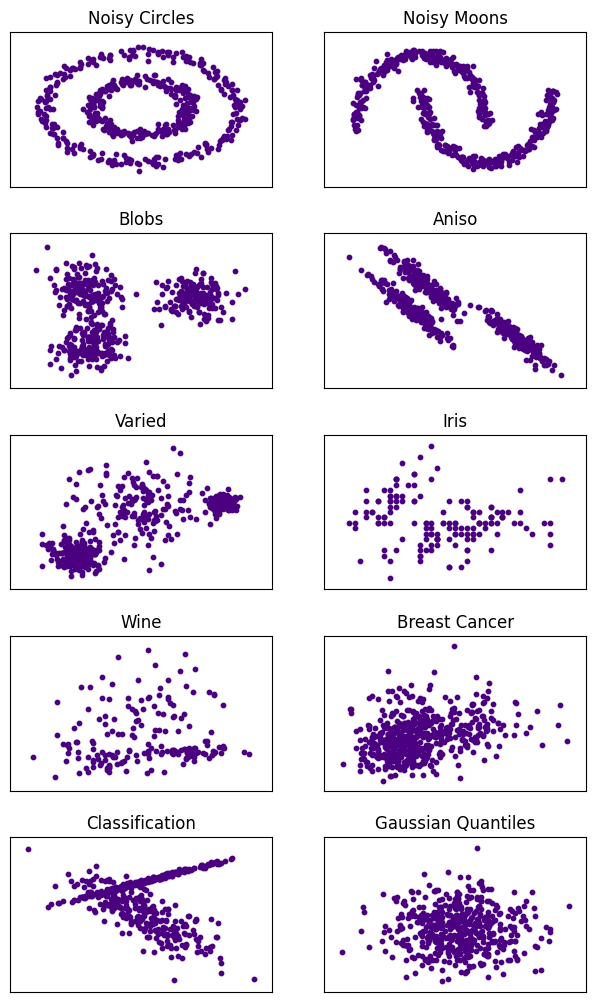

In [26]:
noisy_circles = datasets.make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=30) 
noisy_moons = datasets.make_moons(n_samples=500, noise=0.05, random_state=30) 
blobs = datasets.make_blobs(n_samples=500, random_state=30) 

X, y = datasets.make_blobs(n_samples=500, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
varied = datasets.make_blobs(n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=170)

iris = datasets.load_iris(return_X_y=True)
wine = datasets.load_wine(return_X_y=True)
breast_cancer = datasets.load_breast_cancer(return_X_y=True) 
classification = datasets.make_classification(
    n_samples=500, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2, 
    n_clusters_per_class=1, 
    random_state=42
)
gaussian_quantiles = datasets.make_gaussian_quantiles(n_samples=500, n_features=2, n_classes=2, random_state=42) 

datasets_list_sklearn = [
    noisy_circles, noisy_moons, blobs,
    aniso, varied, iris, wine, breast_cancer, classification, gaussian_quantiles
]
dataset_titles_sklearn = [
    'Noisy Circles', 'Noisy Moons', 'Blobs',
    'Aniso', 'Varied', 'Iris', 'Wine', 'Breast Cancer','Classification', 'Gaussian Quantiles'
]

k_clusters_sklearn = [
    2,2,3,3,3,3,3,2,2,2
    ]

n_cols = 2
n_rows = 5
fig_size = (4 * n_cols * 0.8, 3 * n_rows * 0.8)
plt.figure(figsize=fig_size)
plt.subplots_adjust(
    left=0.05, right=0.95, bottom=0.05, top=0.85, wspace=0.2, hspace=0.3
)

for i, (dataset, title) in enumerate(zip(datasets_list_sklearn, dataset_titles_sklearn)):
    if len(dataset) == 2:
        X, _ = dataset  
    else:
        X, _ = dataset
    X = StandardScaler().fit_transform(X)
    
    plt.subplot(n_rows, n_cols, i + 1)
    plt.title(title, size=12)
    
    plt.scatter(X[:, 0], X[:, 1], s=10, color="indigo")
    plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    plt.xticks(())
    plt.yticks(())

plt.show()

## Testes

In [38]:
# Execução de todos os experimentos de acordo com os parâmetros definidos
def executeAll(data, k_clusters, n_distance, labels, nome_test, n_experimentos=30):
    pontos = data.tolist()
    distMatrix = calculateDistances(pontos, n_distance)

    # Armazenar resultados do Algoritmo 1
    resultados = []

    percentages = np.linspace(0.14, 0.25, num=5)
    
    for percentage in percentages:
        percentage = np.around(percentage, decimals=3)
        dur_alg1 = []
        max_rai_alg1 = []
        mean_rai_alg1 = []
        sil_alg1 = []
        ra_alg1 = []
        for _ in range(n_experimentos):
            # Algoritmo 1

            start_time = datetime.now()
            clusters_1, raios_1, sil_1, r_1 = k_clustering(pontos, percentage, k_clusters, n_distance, distMatrix, labels)
            end_time = datetime.now()
            duration = (end_time - start_time).total_seconds() * 1000

            dur_alg1.append(duration)
            raios_1 = [sublista[0] for sublista in raios_1]
            max_rai_alg1.append(max(raios_1))
            mean_rai_alg1.append(statistics.mean(raios_1))
            sil_alg1.append(sil_1)
            ra_alg1.append(r_1)

        # Calculando médias para o Algoritmo 1
        mean_dur_alg1 = round(np.mean(dur_alg1), 4)
        mean_max_rai_alg1 = round(np.mean(max_rai_alg1), 4)
        mean_mean_rai_alg1 = round(np.mean(mean_rai_alg1), 4)
        mean_sil_alg1 = round(np.mean(sil_alg1), 4)
        mean_ra_alg1 = round(np.mean(ra_alg1), 4)

        # Adicionando resultados à lista
        resultados.append({
            'Modelo': f"Algoritmo 1 com intervalo {percentage}",
            'Duração Algoritmo (ms)': mean_dur_alg1,
            'Maior Raio': mean_max_rai_alg1,
            'Média Raios': mean_mean_rai_alg1,
            'Silhueta': mean_sil_alg1,
            'Índice de Rand Ajustado': mean_ra_alg1,
        })

    # Inicializar listas para o Algoritmo 2
    dur_alg2 = []
    max_rai_alg2 = []
    mean_rai_alg2 = []
    sil_alg2 = []
    ra_alg2 = []

    # Executando Algoritmo 2 30 vezes
    for _ in range(n_experimentos):
        start_time = datetime.now()
        clusters_2, raios_2, sil_2, r_2 = makeClusters(pontos, k_clusters, n_distance, distMatrix, labels)
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() * 1000

        dur_alg2.append(duration)
        raios_2 = [sublista[0] for sublista in raios_2]
        max_rai_alg2.append(max(raios_2))
        mean_rai_alg2.append(statistics.mean(raios_2))
        sil_alg2.append(sil_2)
        ra_alg2.append(r_2)

    # Calculando médias para o Algoritmo 2
    mean_dur_alg2 = round(np.mean(dur_alg2), 4)
    mean_max_rai_alg2 = round(np.mean(max_rai_alg2), 4)
    mean_mean_rai_alg2 = round(np.mean(mean_rai_alg2), 4)
    mean_sil_alg2 = round(np.mean(sil_alg2), 4)
    mean_ra_alg2 = round(np.mean(ra_alg2), 4)

    resultados.append({
        'Modelo': "Algoritmo 2",
        'Duração Algoritmo (ms)': mean_dur_alg2,
        'Maior Raio': mean_max_rai_alg2,
        'Média Raios': mean_mean_rai_alg2,
        'Silhueta': mean_sil_alg2,
        'Índice de Rand Ajustado': mean_ra_alg2,
    })
    
    # Executando Kmeans (apenas uma vez)
    start_time = datetime.now()
    clusters_kmeans, raios_kmeans, sil_kmeans, r_kmeans = performKmeans(pontos, labels, k_clusters)
    end_time = datetime.now()
    duration_kmeans = (end_time - start_time).total_seconds() * 1000

    max_rai_kmeans = round(max(raios_kmeans), 4)
    mean_rai_kmeans = round(statistics.mean(raios_kmeans), 4)

    # Adicionando resultados do Algoritmo 2 e Kmeans à lista
    resultados.append({
        'Modelo': "Kmeans",
        'Duração Algoritmo (ms)': round(duration_kmeans, 4),
        'Maior Raio': max_rai_kmeans,
        'Média Raios': mean_rai_kmeans,
        'Silhueta': round(sil_kmeans, 4),
        'Índice de Rand Ajustado': round(r_kmeans, 4),
    })

    # Preparando a tabela de resultados
    report_table_df = pd.DataFrame(resultados)

    return report_table_df


### Normal multivariada com Distância 1

Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.1 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,6.6466,3.7279,2.7987,0.2864,0.1821
1,Algoritmo 1 com intervalo 0.168,4.2348,3.7279,2.7987,0.2864,0.1821
2,Algoritmo 1 com intervalo 0.195,4.3468,3.7279,2.7987,0.2864,0.1821
3,Algoritmo 1 com intervalo 0.222,5.1205,3.7279,2.7987,0.2864,0.1821
4,Algoritmo 1 com intervalo 0.25,6.1845,3.7279,2.7987,0.2864,0.1821
5,Algoritmo 2,7.0887,2.7190,2.6825,0.6210,0.8830
6,Kmeans,4.9170,1.6661,1.6096,0.6458,0.9800


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,9.1295,4.5536,2.2718,0.2638,0.0000
1,Algoritmo 1 com intervalo 0.168,8.0000,4.5536,2.2718,0.2638,0.0000
2,Algoritmo 1 com intervalo 0.195,8.4201,4.5536,2.2718,0.2638,0.0000
3,Algoritmo 1 com intervalo 0.222,7.1121,4.5536,2.2718,0.2638,0.0000
4,Algoritmo 1 com intervalo 0.25,11.7486,4.5536,2.2718,0.2638,0.0000
5,Algoritmo 2,15.3280,3.7157,3.1625,0.2652,0.0359
6,Kmeans,5.6740,2.7090,2.3429,0.3496,0.1192


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.3 e 8 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,73.5512,3.1712,2.4832,0.1723,0.0274
1,Algoritmo 1 com intervalo 0.168,79.5414,3.1712,2.4832,0.1723,0.0274
2,Algoritmo 1 com intervalo 0.195,78.1285,3.1712,2.4832,0.1723,0.0274
3,Algoritmo 1 com intervalo 0.222,89.8261,3.1712,2.4832,0.1723,0.0274
4,Algoritmo 1 com intervalo 0.25,87.2022,3.1712,2.4832,0.1723,0.0274
5,Algoritmo 2,502.0937,2.1280,1.7538,0.2432,0.1235
6,Kmeans,136.6630,1.9176,1.3705,0.3287,0.1297


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 1.0 e 4 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,12.3158,4.7382,2.3691,0.3807,0.0000
1,Algoritmo 1 com intervalo 0.168,13.6597,4.7382,2.3691,0.3807,0.0000
2,Algoritmo 1 com intervalo 0.195,12.8039,4.7382,2.3691,0.3807,0.0000
3,Algoritmo 1 com intervalo 0.222,13.9094,4.7382,2.3691,0.3807,0.0000
4,Algoritmo 1 com intervalo 0.25,13.0434,4.7382,2.3691,0.3807,0.0000
5,Algoritmo 2,41.6882,3.5073,3.0239,0.2227,0.0056
6,Kmeans,9.3650,2.4718,2.2432,0.3013,0.0116


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.2 e 10 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,115.8866,2.3107,1.9673,0.1540,0.0786
1,Algoritmo 1 com intervalo 0.168,115.4671,2.3107,1.9673,0.1540,0.0786
2,Algoritmo 1 com intervalo 0.195,111.1784,2.3107,1.9673,0.1540,0.0786
3,Algoritmo 1 com intervalo 0.222,114.6037,2.3107,1.9673,0.1540,0.0786
4,Algoritmo 1 com intervalo 0.25,113.2693,2.3107,1.9673,0.1540,0.0786
5,Algoritmo 2,1189.9956,1.7653,1.4526,0.1861,0.0837
6,Kmeans,144.9960,1.7115,1.1381,0.3245,0.1303


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.7 e 5 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,30.7171,2.8998,2.6083,0.1292,0.0011
1,Algoritmo 1 com intervalo 0.168,38.0943,2.8998,2.6083,0.1292,0.0011
2,Algoritmo 1 com intervalo 0.195,33.8193,2.8998,2.6083,0.1292,0.0011
3,Algoritmo 1 com intervalo 0.222,37.5930,2.8998,2.6083,0.1292,0.0011
4,Algoritmo 1 com intervalo 0.25,34.6343,2.8998,2.6083,0.1292,0.0011
5,Algoritmo 2,152.4319,2.7780,2.3439,0.2035,0.0102
6,Kmeans,41.9430,2.2608,1.8715,0.3236,0.0434


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.4 e 7 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,62.1788,3.2478,2.3123,0.1322,0.0030
1,Algoritmo 1 com intervalo 0.168,62.3727,3.2478,2.3123,0.1322,0.0030
2,Algoritmo 1 com intervalo 0.195,65.9966,3.2478,2.3123,0.1322,0.0030
3,Algoritmo 1 com intervalo 0.222,62.7518,3.2478,2.3123,0.1322,0.0030
4,Algoritmo 1 com intervalo 0.25,58.9630,3.2478,2.3123,0.1322,0.0030
5,Algoritmo 2,346.6150,2.5737,2.2335,0.1640,0.0386
6,Kmeans,135.0760,2.6817,1.6174,0.3096,0.1034


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 1.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,8.4432,4.2815,2.8533,0.3451,0.0000
1,Algoritmo 1 com intervalo 0.168,8.2189,4.2815,2.8533,0.3451,0.0000
2,Algoritmo 1 com intervalo 0.195,8.2664,4.2815,2.8533,0.3451,0.0000
3,Algoritmo 1 com intervalo 0.222,8.3782,4.2815,2.8533,0.3451,0.0000
4,Algoritmo 1 com intervalo 0.25,10.1657,4.2815,2.8533,0.3451,0.0000
5,Algoritmo 2,16.6816,3.4618,3.2130,0.2608,-0.0020
6,Kmeans,5.4510,2.6069,2.3104,0.3820,-0.0012


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.6 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,3.1301,5.6116,5.6116,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,2.9056,5.6116,5.6116,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,2.8631,5.6116,5.6116,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,2.8817,5.6116,5.6116,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,2.8048,5.6116,5.6116,0.0000,0.0000
5,Algoritmo 2,5.1881,4.8771,4.1260,0.2932,0.0370
6,Kmeans,6.3250,2.8045,2.4939,0.3561,0.0578


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.9 e 6 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,44.8660,3.5796,3.0278,0.1823,0.0135
1,Algoritmo 1 com intervalo 0.168,46.7044,3.5796,3.0278,0.1823,0.0135
2,Algoritmo 1 com intervalo 0.195,51.4116,3.5796,3.0278,0.1823,0.0135
3,Algoritmo 1 com intervalo 0.222,47.6459,3.5796,3.0278,0.1823,0.0135
4,Algoritmo 1 com intervalo 0.25,50.9643,3.5796,3.0278,0.1823,0.0135
5,Algoritmo 2,229.8542,3.0634,2.4226,0.1912,0.0173
6,Kmeans,140.7120,2.7541,1.7828,0.3202,0.0408


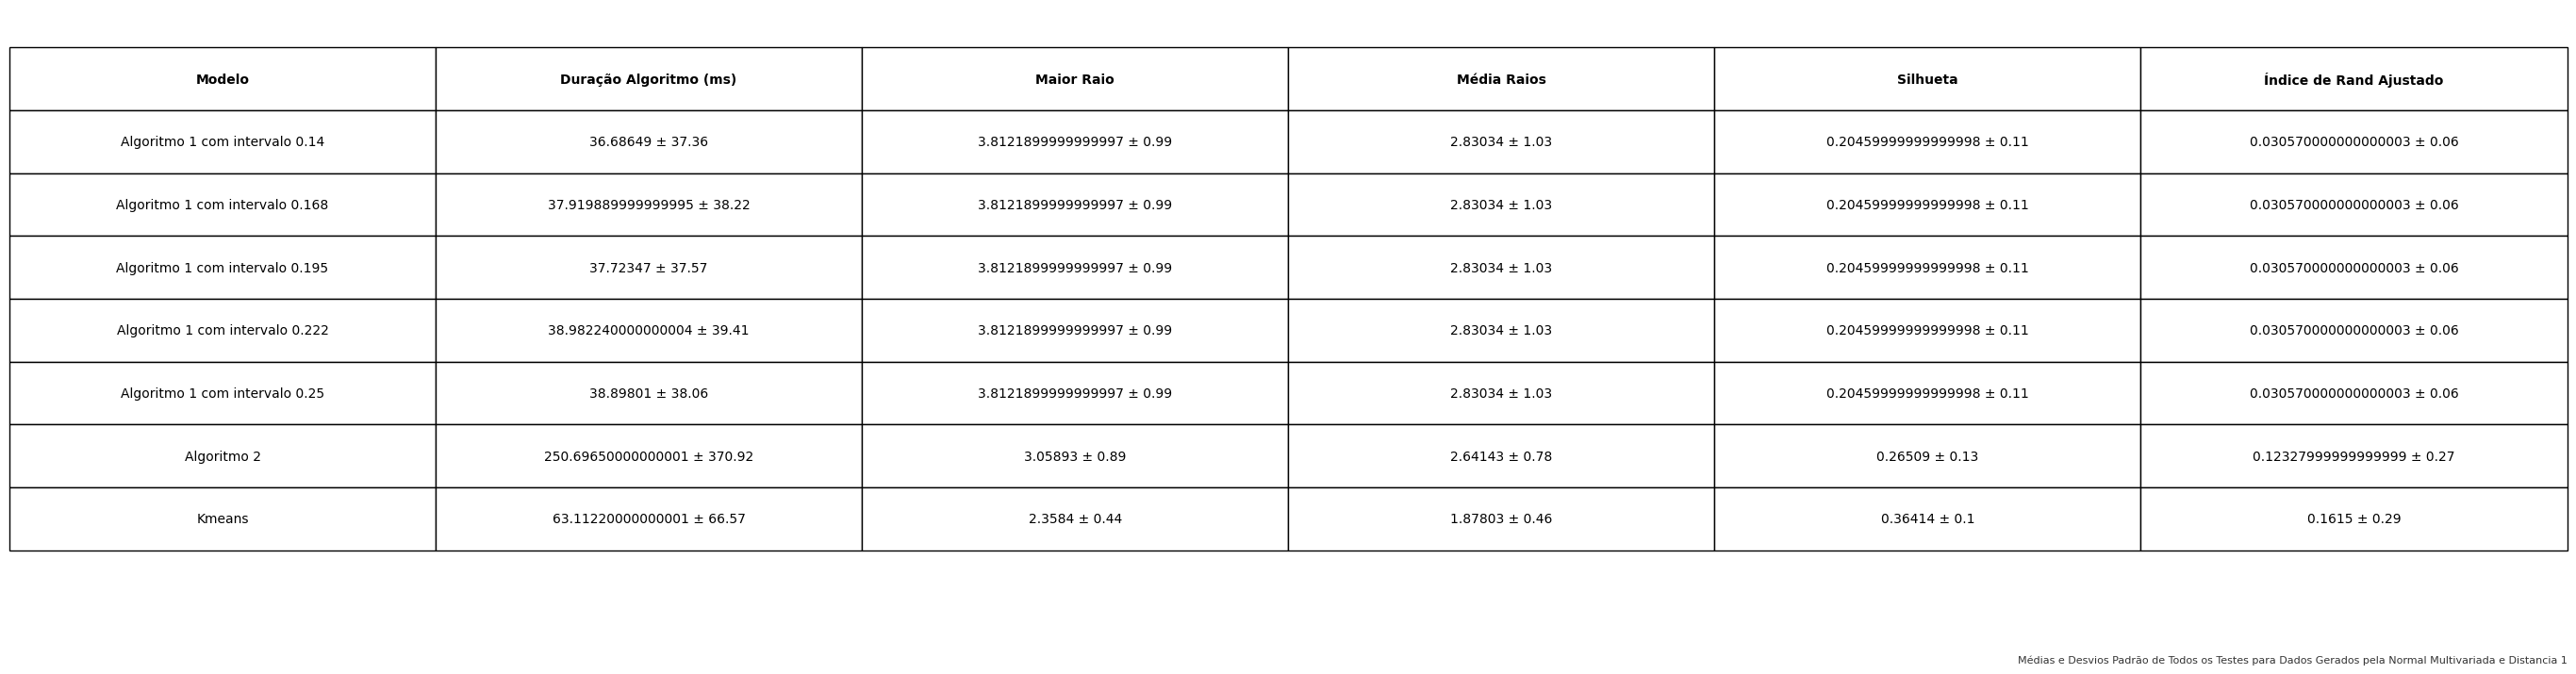

Latex da tabela:
\begin{tabular}{llllll}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 36.68649 ± 37.36 & 3.8121899999999997 ± 0.99 & 2.83034 ± 1.03 & 0.20459999999999998 ± 0.11 & 0.030570000000000003 ± 0.06 \\
Algoritmo 1 com intervalo 0.168 & 37.919889999999995 ± 38.22 & 3.8121899999999997 ± 0.99 & 2.83034 ± 1.03 & 0.20459999999999998 ± 0.11 & 0.030570000000000003 ± 0.06 \\
Algoritmo 1 com intervalo 0.195 & 37.72347 ± 37.57 & 3.8121899999999997 ± 0.99 & 2.83034 ± 1.03 & 0.20459999999999998 ± 0.11 & 0.030570000000000003 ± 0.06 \\
Algoritmo 1 com intervalo 0.222 & 38.982240000000004 ± 39.41 & 3.8121899999999997 ± 0.99 & 2.83034 ± 1.03 & 0.20459999999999998 ± 0.11 & 0.030570000000000003 ± 0.06 \\
Algoritmo 1 com intervalo 0.25 & 38.89801 ± 38.06 & 3.8121899999999997 ± 0.99 & 2.83034 ± 1.03 & 0.20459999999999998 ± 0.11 & 0.030570000000000003 ± 0.06 \\
Algoritmo 2 & 250.69650000000001 ±

In [39]:
n_experimentos = 30

combined_results = []
dataset_titles = []
for i in range(0,10):
    labels = labels_list_normal[i]  
    nome_test = f"Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters"
    dataset_titles.append("Dataset seguindo uma normal multivariada com desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters")
    data = np.column_stack((data_normal[i][:, 0], data_normal[i][:, 1]))

    df_resultado = executeAll(np.array(data), n_clusters_normal[i], 1, labels, nome_test, n_experimentos)
    
    print(nome_test)
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles)
mean_results = combined_df.groupby("Modelo").mean().reset_index()
std_results = combined_df.groupby("Modelo").std().reset_index()

results_with_std = mean_results.copy()
for col in mean_results.columns[1:]:
    results_with_std[col] = mean_results[col].astype(str) + " ± " + std_results[col].round(2).astype(str)

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias e Desvios Padrão de Todos os Testes para Dados Gerados pela Normal Multivariada e Distancia 1", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=results_with_std.values, colLabels=results_with_std.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = results_with_std.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Normal multivariada com Distância 2

Resultados para a dataset gerado com o desvio padrão 0.1 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,5.5680,2.7798,2.1487,0.2387,0.1064
1,Algoritmo 1 com intervalo 0.168,5.5085,2.7798,2.1487,0.2387,0.1064
2,Algoritmo 1 com intervalo 0.195,5.4500,2.7798,2.1487,0.2387,0.1064
3,Algoritmo 1 com intervalo 0.222,5.6320,2.7798,2.1487,0.2387,0.1064
4,Algoritmo 1 com intervalo 0.25,5.2627,2.7798,2.1487,0.2387,0.1064
5,Algoritmo 2,5.9010,2.3010,2.2900,0.5674,0.7211
6,Kmeans,5.3950,1.6661,1.6096,0.6458,0.9800


Resultados para a dataset gerado com o desvio padrão 0.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,6.2493,3.8013,3.8013,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,4.6730,3.8013,3.8013,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,4.5709,3.8013,3.8013,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,4.7738,3.8013,3.8013,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,4.6314,3.8013,3.8013,0.0000,0.0000
5,Algoritmo 2,16.4001,2.7466,2.4706,0.2815,0.0433
6,Kmeans,6.6420,2.7090,2.3429,0.3496,0.1192


Resultados para a dataset gerado com o desvio padrão 0.3 e 8 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,85.9316,2.3271,1.7054,0.2106,0.0453
1,Algoritmo 1 com intervalo 0.168,84.9578,2.3271,1.7054,0.2106,0.0453
2,Algoritmo 1 com intervalo 0.195,87.5751,2.3271,1.7054,0.2106,0.0453
3,Algoritmo 1 com intervalo 0.222,91.0967,2.3271,1.7054,0.2106,0.0453
4,Algoritmo 1 com intervalo 0.25,92.1341,2.3271,1.7054,0.2106,0.0453
5,Algoritmo 2,517.8683,1.7913,1.5498,0.1767,0.0733
6,Kmeans,152.5090,1.9176,1.3705,0.3287,0.1297


Resultados para a dataset gerado com o desvio padrão 1.0 e 4 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,11.2779,2.4261,1.9103,0.1783,0.0003
1,Algoritmo 1 com intervalo 0.168,10.9735,2.4261,1.9103,0.1783,0.0003
2,Algoritmo 1 com intervalo 0.195,11.3811,2.4261,1.9103,0.1783,0.0003
3,Algoritmo 1 com intervalo 0.222,11.1602,2.4261,1.9103,0.1783,0.0003
4,Algoritmo 1 com intervalo 0.25,11.1221,2.4261,1.9103,0.1783,0.0003
5,Algoritmo 2,42.7339,2.7032,2.1958,0.2239,0.0079
6,Kmeans,5.9130,2.4718,2.2432,0.3013,0.0116


Resultados para a dataset gerado com o desvio padrão 0.2 e 10 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,108.4901,1.7147,1.2751,0.2049,0.0760
1,Algoritmo 1 com intervalo 0.168,116.9673,1.7147,1.2751,0.2049,0.0760
2,Algoritmo 1 com intervalo 0.195,118.6302,1.7147,1.2751,0.2049,0.0760
3,Algoritmo 1 com intervalo 0.222,113.4901,1.7147,1.2751,0.2049,0.0760
4,Algoritmo 1 com intervalo 0.25,118.4529,1.7147,1.2751,0.2049,0.0760
5,Algoritmo 2,1098.3760,1.4366,1.3216,0.1661,0.0908
6,Kmeans,141.5080,1.7115,1.1381,0.3245,0.1303


Resultados para a dataset gerado com o desvio padrão 0.7 e 5 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,33.5119,2.3647,1.6186,0.1110,0.0009
1,Algoritmo 1 com intervalo 0.168,34.3599,2.3647,1.6186,0.1110,0.0009
2,Algoritmo 1 com intervalo 0.195,33.3773,2.3647,1.6186,0.1110,0.0009
3,Algoritmo 1 com intervalo 0.222,34.3825,2.3647,1.6186,0.1110,0.0009
4,Algoritmo 1 com intervalo 0.25,33.0813,2.3647,1.6186,0.1110,0.0009
5,Algoritmo 2,169.5378,2.4302,2.0269,0.1837,0.0091
6,Kmeans,14.9180,2.2608,1.8715,0.3236,0.0434


Resultados para a dataset gerado com o desvio padrão 0.4 e 7 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,55.6806,2.5426,1.3671,0.1714,0.0048
1,Algoritmo 1 com intervalo 0.168,56.9704,2.5426,1.3671,0.1714,0.0048
2,Algoritmo 1 com intervalo 0.195,57.4223,2.5426,1.3671,0.1714,0.0048
3,Algoritmo 1 com intervalo 0.222,57.1205,2.5426,1.3671,0.1714,0.0048
4,Algoritmo 1 com intervalo 0.25,56.8455,2.5426,1.3671,0.1714,0.0048
5,Algoritmo 2,341.4767,1.9337,1.7654,0.1656,0.0426
6,Kmeans,138.8300,2.6817,1.6174,0.3096,0.1034


Resultados para a dataset gerado com o desvio padrão 1.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,8.0963,3.7017,1.8508,0.428,0.0000
1,Algoritmo 1 com intervalo 0.168,7.8319,3.7017,1.8508,0.428,0.0000
2,Algoritmo 1 com intervalo 0.195,7.8416,3.7017,1.8508,0.428,0.0000
3,Algoritmo 1 com intervalo 0.222,8.2486,3.7017,1.8508,0.428,0.0000
4,Algoritmo 1 com intervalo 0.25,7.8365,3.7017,1.8508,0.428,0.0000
5,Algoritmo 2,14.9576,2.6181,2.3212,0.229,-0.0025
6,Kmeans,4.9770,2.6069,2.3104,0.382,-0.0012


Resultados para a dataset gerado com o desvio padrão 0.6 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,4.4049,3.9369,1.9685,0.3701,0.0000
1,Algoritmo 1 com intervalo 0.168,4.4987,3.9369,1.9685,0.3701,0.0000
2,Algoritmo 1 com intervalo 0.195,4.5409,3.9369,1.9685,0.3701,0.0000
3,Algoritmo 1 com intervalo 0.222,4.5447,3.9369,1.9685,0.3701,0.0000
4,Algoritmo 1 com intervalo 0.25,4.4785,3.9369,1.9685,0.3701,0.0000
5,Algoritmo 2,5.4022,3.4599,3.1636,0.2921,0.0293
6,Kmeans,4.2880,2.8045,2.4939,0.3561,0.0578


Resultados para a dataset gerado com o desvio padrão 0.9 e 6 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,52.3774,2.6552,2.3307,0.2201,0.0213
1,Algoritmo 1 com intervalo 0.168,48.3810,2.6552,2.3307,0.2201,0.0213
2,Algoritmo 1 com intervalo 0.195,49.4664,2.6552,2.3307,0.2201,0.0213
3,Algoritmo 1 com intervalo 0.222,53.8670,2.6552,2.3307,0.2201,0.0213
4,Algoritmo 1 com intervalo 0.25,53.7422,2.6552,2.3307,0.2201,0.0213
5,Algoritmo 2,237.4209,2.0560,1.9418,0.1815,0.0155
6,Kmeans,138.1980,2.7541,1.7828,0.3202,0.0408


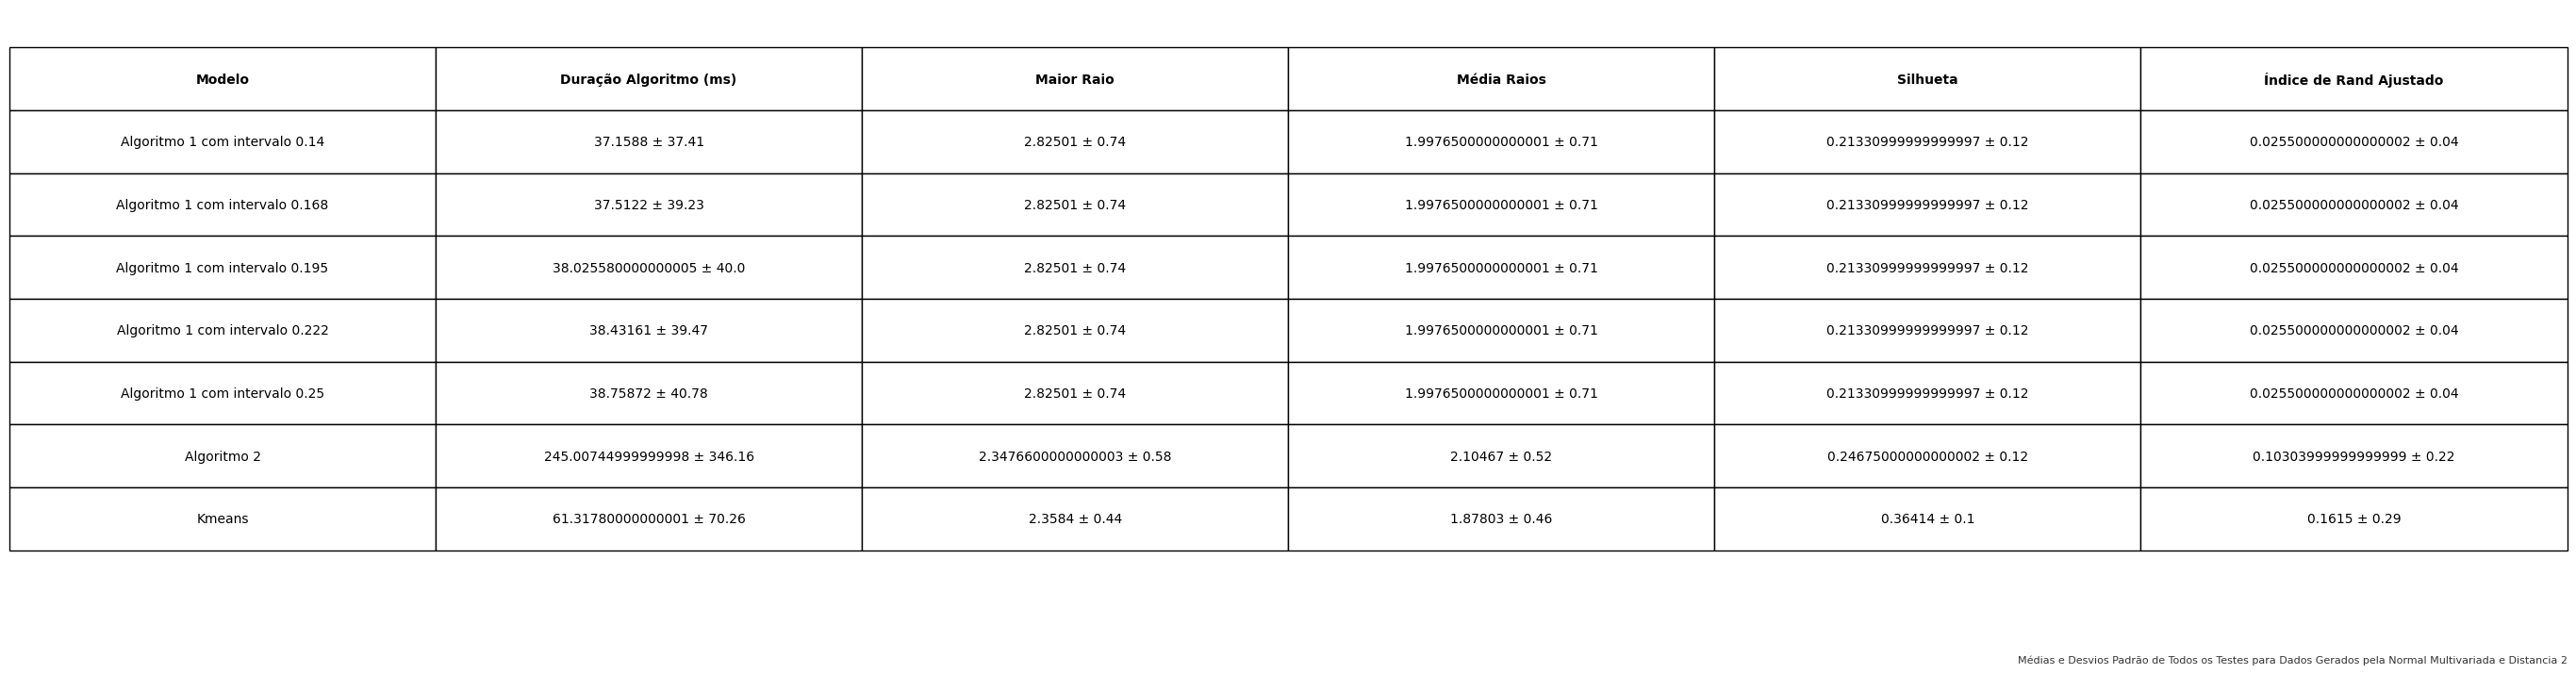

Latex da tabela:
\begin{tabular}{llllll}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 37.1588 ± 37.41 & 2.82501 ± 0.74 & 1.9976500000000001 ± 0.71 & 0.21330999999999997 ± 0.12 & 0.025500000000000002 ± 0.04 \\
Algoritmo 1 com intervalo 0.168 & 37.5122 ± 39.23 & 2.82501 ± 0.74 & 1.9976500000000001 ± 0.71 & 0.21330999999999997 ± 0.12 & 0.025500000000000002 ± 0.04 \\
Algoritmo 1 com intervalo 0.195 & 38.025580000000005 ± 40.0 & 2.82501 ± 0.74 & 1.9976500000000001 ± 0.71 & 0.21330999999999997 ± 0.12 & 0.025500000000000002 ± 0.04 \\
Algoritmo 1 com intervalo 0.222 & 38.43161 ± 39.47 & 2.82501 ± 0.74 & 1.9976500000000001 ± 0.71 & 0.21330999999999997 ± 0.12 & 0.025500000000000002 ± 0.04 \\
Algoritmo 1 com intervalo 0.25 & 38.75872 ± 40.78 & 2.82501 ± 0.74 & 1.9976500000000001 ± 0.71 & 0.21330999999999997 ± 0.12 & 0.025500000000000002 ± 0.04 \\
Algoritmo 2 & 245.00744999999998 ± 346.16 & 2.3

In [40]:
n_experimentos = 30

combined_results = []
dataset_titles = []

for i in range(0,10):
    labels = labels_list_normal[i]  
    nome_test = f"Resultados para a dataset gerado com o desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters"
    data = np.column_stack((data_normal[i][:, 0], data_normal[i][:, 1]))
    dataset_titles.append("Dataset seguindo uma normal multivariada com desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters")

    df_resultado = executeAll(np.array(data), n_clusters_normal[i], 2, labels, nome_test, n_experimentos)
    
    print(nome_test)
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles)
mean_results = combined_df.groupby("Modelo").mean().reset_index()
std_results = combined_df.groupby("Modelo").std().reset_index()

results_with_std = mean_results.copy()
for col in mean_results.columns[1:]:
    results_with_std[col] = mean_results[col].astype(str) + " ± " + std_results[col].round(2).astype(str)

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias e Desvios Padrão de Todos os Testes para Dados Gerados pela Normal Multivariada e Distancia 2", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=results_with_std.values, colLabels=results_with_std.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = results_with_std.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Exemplos do scikit learn com Distância 1

Resultados para Noisy Circles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,32.9358,2.3269,1.7531,0.2337,0.0627
1,Algoritmo 1 com intervalo 0.168,37.9976,2.3269,1.7531,0.2337,0.0627
2,Algoritmo 1 com intervalo 0.195,37.2880,2.3269,1.7531,0.2337,0.0627
3,Algoritmo 1 com intervalo 0.222,35.8321,2.3269,1.7531,0.2337,0.0627
4,Algoritmo 1 com intervalo 0.25,38.1171,2.3269,1.7531,0.2337,0.0627
5,Algoritmo 2,45.6181,1.9307,1.9213,0.3454,0.0016
6,Kmeans,32.5550,1.1543,1.1486,0.3516,-0.0019


Resultados para Noisy Moons


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,10.7632,2.5049,2.5049,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,10.7360,2.5049,2.5049,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,10.9745,2.5049,2.5049,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,10.7659,2.5049,2.5049,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,10.8490,2.5049,2.5049,0.0000,0.0000
5,Algoritmo 2,40.7826,1.6284,1.6215,0.4491,0.3124
6,Kmeans,195.8900,1.0099,1.0036,0.4879,0.2327


Resultados para Blobs


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,33.9670,10.3231,5.1616,0.2534,0.0000
1,Algoritmo 1 com intervalo 0.168,39.8107,10.3231,5.1616,0.2534,0.0000
2,Algoritmo 1 com intervalo 0.195,36.4990,10.3231,5.1616,0.2534,0.0000
3,Algoritmo 1 com intervalo 0.222,36.1873,10.3231,5.1616,0.2534,0.0000
4,Algoritmo 1 com intervalo 0.25,35.2943,10.3231,5.1616,0.2534,0.0000
5,Algoritmo 2,90.2694,7.3351,6.0418,0.3211,0.3780
6,Kmeans,78.4420,4.2143,3.4453,0.6471,0.9703


Resultados para Aniso


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,35.6155,5.9485,5.0297,0.6128,0.5000
1,Algoritmo 1 com intervalo 0.168,38.4346,5.9485,5.0297,0.6128,0.5000
2,Algoritmo 1 com intervalo 0.195,39.8336,5.9485,5.0297,0.6128,0.5000
3,Algoritmo 1 com intervalo 0.222,37.7992,5.9485,5.0297,0.6128,0.5000
4,Algoritmo 1 com intervalo 0.25,39.9554,5.9485,5.0297,0.6128,0.5000
5,Algoritmo 2,97.9012,3.4323,3.4201,0.4038,0.3616
6,Kmeans,32.4590,2.8363,2.6849,0.5007,0.5554


Resultados para Varied


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,44.7927,12.9585,8.6311,0.4761,0.5251
1,Algoritmo 1 com intervalo 0.168,42.7450,12.9585,8.6311,0.4761,0.5251
2,Algoritmo 1 com intervalo 0.195,42.4129,12.9585,8.6311,0.4761,0.5251
3,Algoritmo 1 com intervalo 0.222,43.2790,12.9585,8.6311,0.4761,0.5251
4,Algoritmo 1 com intervalo 0.25,42.6713,12.9585,8.6311,0.4761,0.5251
5,Algoritmo 2,103.8071,10.2227,9.6425,0.5794,0.6076
6,Kmeans,17.7560,6.9001,6.5023,0.6549,0.7872


Resultados para Iris


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,5.5134,1.8000,1.2000,0.0101,0.1524
1,Algoritmo 1 com intervalo 0.168,4.1776,1.8000,1.2000,0.0101,0.1524
2,Algoritmo 1 com intervalo 0.195,4.0940,1.8000,1.2000,0.0101,0.1524
3,Algoritmo 1 com intervalo 0.222,3.9607,1.8000,1.2000,0.0101,0.1524
4,Algoritmo 1 com intervalo 0.25,4.1493,1.8000,1.2000,0.0101,0.1524
5,Algoritmo 2,5.8997,1.7000,1.6000,0.3690,0.4132
6,Kmeans,4.5710,1.6468,1.4821,0.5512,0.7163


Resultados para Wine


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,4.7511,2.6500,2.3667,-0.1570,0.0766
1,Algoritmo 1 com intervalo 0.168,4.7719,2.6500,2.3667,-0.1570,0.0766
2,Algoritmo 1 com intervalo 0.195,4.8150,2.6500,2.3667,-0.1570,0.0766
3,Algoritmo 1 com intervalo 0.222,4.7060,2.6500,2.3667,-0.1570,0.0766
4,Algoritmo 1 com intervalo 0.25,4.8288,2.6500,2.3667,-0.1570,0.0766
5,Algoritmo 2,7.6264,2.9200,2.7167,-0.0228,0.3371
6,Kmeans,4.4220,484.8684,293.9848,0.5711,0.3711


Resultados para Breast Cancer


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,42.3957,26.0670,18.8885,0.0167,0.0009
1,Algoritmo 1 com intervalo 0.168,45.0455,26.0670,18.8885,0.0167,0.0009
2,Algoritmo 1 com intervalo 0.195,56.7984,26.0670,18.8885,0.0167,0.0009
3,Algoritmo 1 com intervalo 0.222,45.7227,26.0670,18.8885,0.0167,0.0009
4,Algoritmo 1 com intervalo 0.25,44.0468,26.0670,18.8885,0.0167,0.0009
5,Algoritmo 2,66.8791,23.7400,22.7500,-0.0272,0.0017
6,Kmeans,83.3470,2862.8902,1754.9912,0.6973,0.4914


Resultados para Classification


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,11.6107,6.9223,6.9223,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,11.3522,6.9223,6.9223,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,12.5716,6.9223,6.9223,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,11.3780,6.9223,6.9223,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,11.2176,6.9223,6.9223,0.0000,0.0000
5,Algoritmo 2,40.2339,6.6107,6.1467,0.1949,0.0021
6,Kmeans,99.8140,3.8161,3.6474,0.5218,0.3589


Resultados para Gaussian Quantiles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,9.9587,6.2880,6.2880,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,10.2897,6.2880,6.2880,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,11.5852,6.2880,6.2880,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,10.2415,6.2880,6.2880,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,10.1785,6.2880,6.2880,0.0000,0.0000
5,Algoritmo 2,46.1114,4.9814,4.4289,0.2940,0.0840
6,Kmeans,16.0490,3.3137,3.2490,0.3207,-0.0012


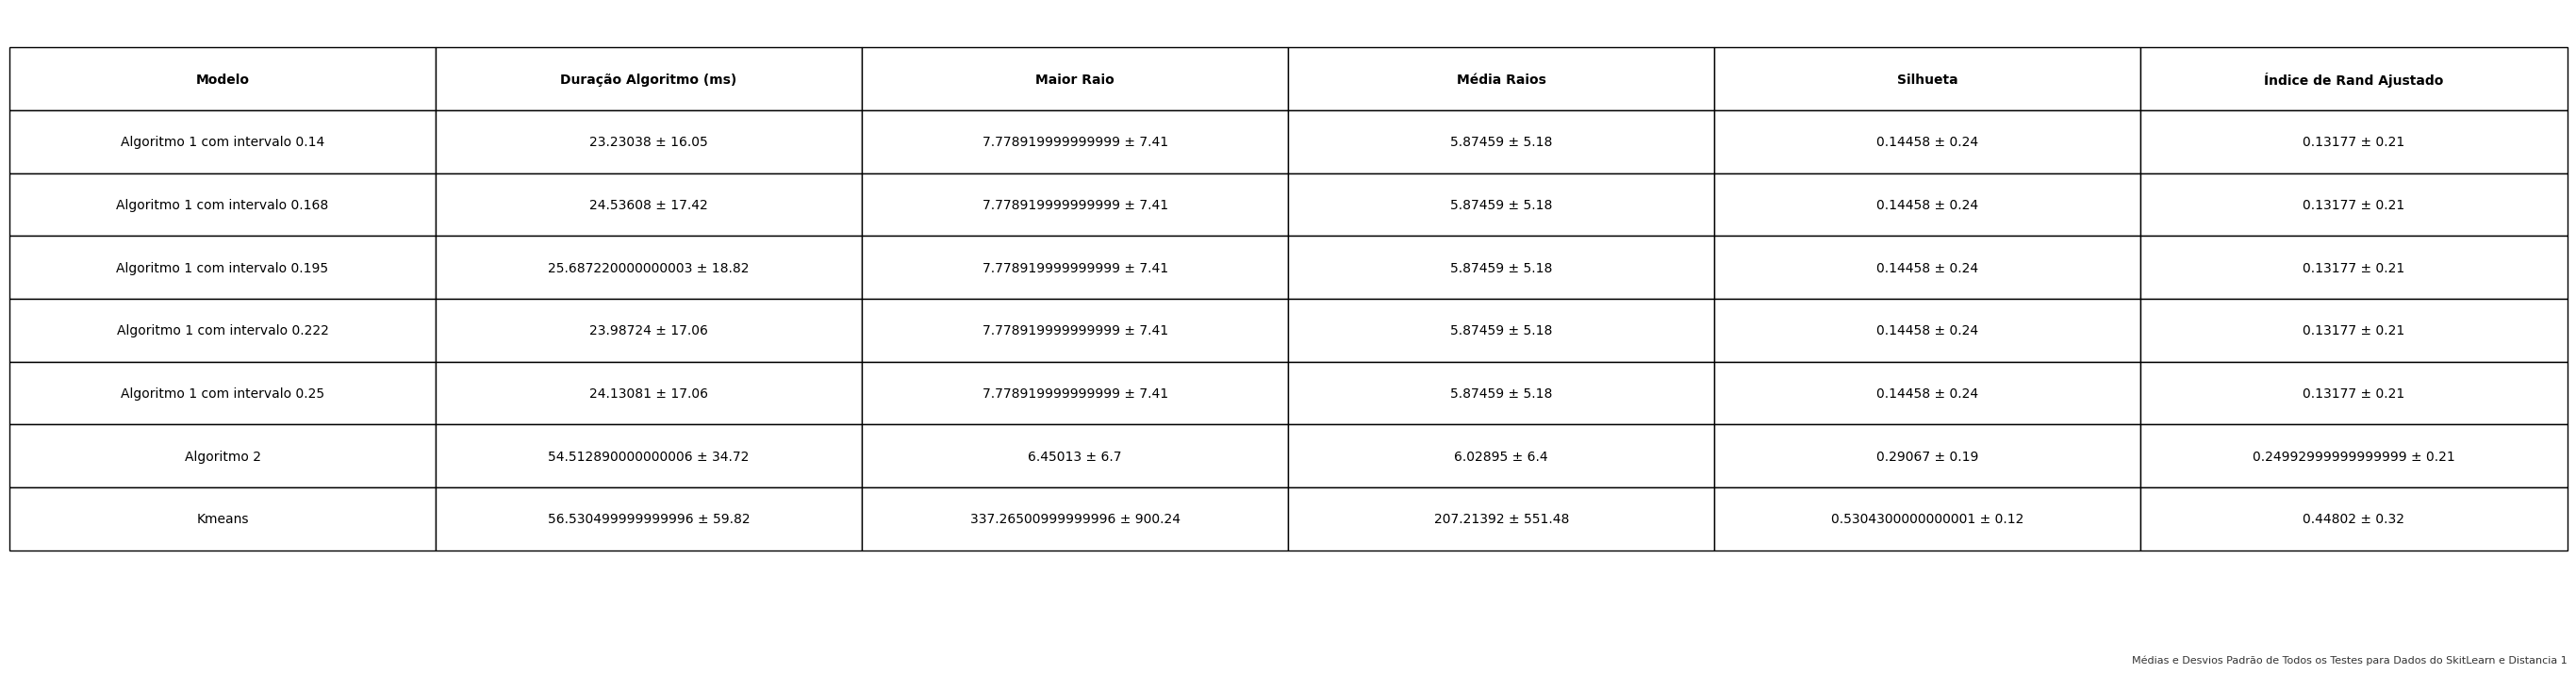

Latex da tabela:
\begin{tabular}{llllll}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 23.23038 ± 16.05 & 7.778919999999999 ± 7.41 & 5.87459 ± 5.18 & 0.14458 ± 0.24 & 0.13177 ± 0.21 \\
Algoritmo 1 com intervalo 0.168 & 24.53608 ± 17.42 & 7.778919999999999 ± 7.41 & 5.87459 ± 5.18 & 0.14458 ± 0.24 & 0.13177 ± 0.21 \\
Algoritmo 1 com intervalo 0.195 & 25.687220000000003 ± 18.82 & 7.778919999999999 ± 7.41 & 5.87459 ± 5.18 & 0.14458 ± 0.24 & 0.13177 ± 0.21 \\
Algoritmo 1 com intervalo 0.222 & 23.98724 ± 17.06 & 7.778919999999999 ± 7.41 & 5.87459 ± 5.18 & 0.14458 ± 0.24 & 0.13177 ± 0.21 \\
Algoritmo 1 com intervalo 0.25 & 24.13081 ± 17.06 & 7.778919999999999 ± 7.41 & 5.87459 ± 5.18 & 0.14458 ± 0.24 & 0.13177 ± 0.21 \\
Algoritmo 2 & 54.512890000000006 ± 34.72 & 6.45013 ± 6.7 & 6.02895 ± 6.4 & 0.29067 ± 0.19 & 0.24992999999999999 ± 0.21 \\
Kmeans & 56.530499999999996 ± 59.82 & 337.2650099999

In [41]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster in zip(datasets_list_sklearn, dataset_titles_sklearn,k_clusters_sklearn):
    labels = data[1]  
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 1, labels, nome_test, n_experimentos)
    
    print(f"Resultados para {title}")
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles_sklearn)
mean_results = combined_df.groupby("Modelo").mean().reset_index()
std_results = combined_df.groupby("Modelo").std().reset_index()

results_with_std = mean_results.copy()
for col in mean_results.columns[1:]:
    results_with_std[col] = mean_results[col].astype(str) + " ± " + std_results[col].round(2).astype(str)

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias e Desvios Padrão de Todos os Testes para Dados do SkitLearn e Distancia 1", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=results_with_std.values, colLabels=results_with_std.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = results_with_std.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Exemplos do scikit learn com Distância 2

Resultados para Noisy Circles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,141.4762,1.8550,1.5776,0.2428,0.0731
1,Algoritmo 1 com intervalo 0.168,42.2740,1.9029,1.5885,0.2271,0.0530
2,Algoritmo 1 com intervalo 0.195,15.2031,2.1084,2.1084,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,12.4687,2.1084,2.1084,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,12.4409,2.1084,2.1084,0.0000,0.0000
5,Algoritmo 2,55.7108,1.5618,1.5468,0.3510,-0.0018
6,Kmeans,18.6260,1.1543,1.1486,0.3516,-0.0019


Resultados para Noisy Moons


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,40.0849,1.7530,1.3727,0.3522,0.0820
1,Algoritmo 1 com intervalo 0.168,44.7131,1.7530,1.3727,0.3522,0.0820
2,Algoritmo 1 com intervalo 0.195,43.7409,1.7530,1.3727,0.3522,0.0820
3,Algoritmo 1 com intervalo 0.222,42.2838,1.7530,1.3727,0.3522,0.0820
4,Algoritmo 1 com intervalo 0.25,40.0561,1.7530,1.3727,0.3522,0.0820
5,Algoritmo 2,43.4146,1.2239,1.2092,0.4413,0.2609
6,Kmeans,35.5330,1.0099,1.0036,0.4879,0.2327


Resultados para Blobs


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,38.8625,7.3925,4.7488,0.2330,0.0004
1,Algoritmo 1 com intervalo 0.168,39.0458,7.3925,4.7488,0.2330,0.0004
2,Algoritmo 1 com intervalo 0.195,36.8953,7.3925,4.7488,0.2330,0.0004
3,Algoritmo 1 com intervalo 0.222,37.0811,7.3925,4.7488,0.2330,0.0004
4,Algoritmo 1 com intervalo 0.25,36.4792,7.3925,4.7488,0.2330,0.0004
5,Algoritmo 2,91.5878,5.3412,4.3739,0.3565,0.4188
6,Kmeans,72.3140,4.2143,3.4453,0.6471,0.9703


Resultados para Aniso


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,39.0492,4.2437,3.9674,0.6231,0.5176
1,Algoritmo 1 com intervalo 0.168,40.4948,4.2437,3.9674,0.6231,0.5176
2,Algoritmo 1 com intervalo 0.195,37.9477,4.2437,3.9674,0.6231,0.5176
3,Algoritmo 1 com intervalo 0.222,40.4954,4.2437,3.9674,0.6231,0.5176
4,Algoritmo 1 com intervalo 0.25,43.4522,4.2437,3.9674,0.6231,0.5176
5,Algoritmo 2,94.5065,3.0512,2.9975,0.4508,0.4519
6,Kmeans,74.0090,2.8363,2.6849,0.5007,0.5554


Resultados para Varied


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,47.8331,9.3795,6.8884,0.5232,0.5087
1,Algoritmo 1 com intervalo 0.168,42.9096,9.3795,6.8884,0.5232,0.5087
2,Algoritmo 1 com intervalo 0.195,42.1185,9.3795,6.8884,0.5232,0.5087
3,Algoritmo 1 com intervalo 0.222,43.7804,9.3795,6.8884,0.5232,0.5087
4,Algoritmo 1 com intervalo 0.25,42.0655,9.3795,6.8884,0.5232,0.5087
5,Algoritmo 2,90.2712,8.1797,7.6437,0.6013,0.6129
6,Kmeans,35.3020,6.9001,6.5023,0.6549,0.7872


Resultados para Iris


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,5.0656,1.3892,1.2299,0.0657,0.1647
1,Algoritmo 1 com intervalo 0.168,5.5599,1.3892,1.2299,0.0657,0.1647
2,Algoritmo 1 com intervalo 0.195,4.3786,1.3892,1.2299,0.0657,0.1647
3,Algoritmo 1 com intervalo 0.222,4.1971,1.3892,1.2299,0.0657,0.1647
4,Algoritmo 1 com intervalo 0.25,4.0973,1.3892,1.2299,0.0657,0.1647
5,Algoritmo 2,6.5265,1.5033,1.2466,0.3707,0.3834
6,Kmeans,4.5070,1.6468,1.4821,0.5512,0.7163


Resultados para Wine


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,4.5509,3.9742,2.2848,-0.1781,0.0004
1,Algoritmo 1 com intervalo 0.168,4.3611,3.9742,2.2848,-0.1781,0.0004
2,Algoritmo 1 com intervalo 0.195,4.3949,3.9742,2.2848,-0.1781,0.0004
3,Algoritmo 1 com intervalo 0.222,4.4158,3.9742,2.2848,-0.1781,0.0004
4,Algoritmo 1 com intervalo 0.25,4.4464,3.9742,2.2848,-0.1781,0.0004
5,Algoritmo 2,7.9691,2.2771,2.2681,-0.0250,0.3483
6,Kmeans,4.9810,484.8684,293.9848,0.5711,0.3711


Resultados para Breast Cancer


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,54.8663,16.9935,14.9680,0.2599,0.0107
1,Algoritmo 1 com intervalo 0.168,54.2606,16.9935,14.9680,0.2599,0.0107
2,Algoritmo 1 com intervalo 0.195,52.4363,16.9935,14.9680,0.2599,0.0107
3,Algoritmo 1 com intervalo 0.222,53.4624,16.9935,14.9680,0.2599,0.0107
4,Algoritmo 1 com intervalo 0.25,56.0098,16.9935,14.9680,0.2599,0.0107
5,Algoritmo 2,69.0246,17.4688,17.2046,0.2288,0.0407
6,Kmeans,142.0880,2862.8902,1754.9912,0.6973,0.4914


Resultados para Classification


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,12.0251,4.9541,4.9541,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,11.4275,4.9541,4.9541,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,11.7945,4.9541,4.9541,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,11.5926,4.9541,4.9541,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,11.5737,4.9541,4.9541,0.0000,0.0000
5,Algoritmo 2,41.8721,4.7353,3.6072,0.1570,0.0025
6,Kmeans,23.1430,3.8161,3.6474,0.5218,0.3589


Resultados para Gaussian Quantiles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,10.6378,4.5092,4.5092,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,10.3780,4.5092,4.5092,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,13.0332,4.5092,4.5092,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,10.9866,4.5092,4.5092,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,10.4817,4.5092,4.5092,0.0000,0.0000
5,Algoritmo 2,49.8240,3.6284,3.4351,0.2980,0.0864
6,Kmeans,15.9970,3.3137,3.2490,0.3207,-0.0012


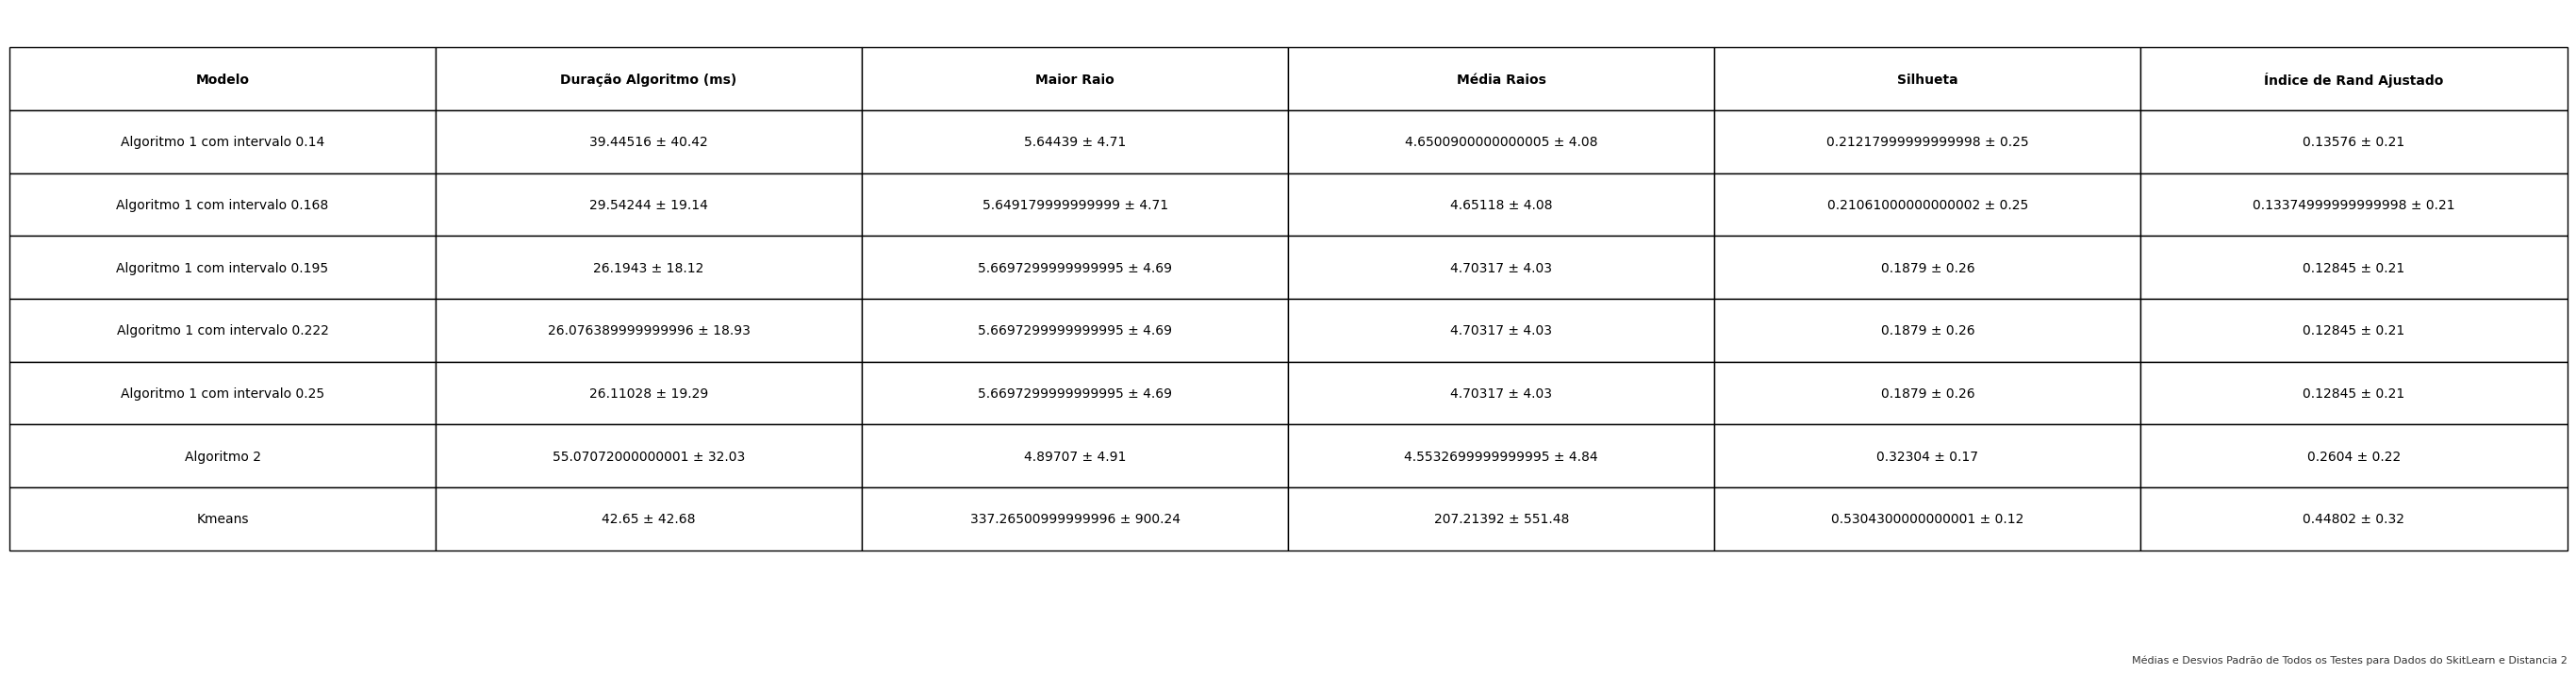

Latex da tabela:
\begin{tabular}{llllll}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 39.44516 ± 40.42 & 5.64439 ± 4.71 & 4.6500900000000005 ± 4.08 & 0.21217999999999998 ± 0.25 & 0.13576 ± 0.21 \\
Algoritmo 1 com intervalo 0.168 & 29.54244 ± 19.14 & 5.649179999999999 ± 4.71 & 4.65118 ± 4.08 & 0.21061000000000002 ± 0.25 & 0.13374999999999998 ± 0.21 \\
Algoritmo 1 com intervalo 0.195 & 26.1943 ± 18.12 & 5.6697299999999995 ± 4.69 & 4.70317 ± 4.03 & 0.1879 ± 0.26 & 0.12845 ± 0.21 \\
Algoritmo 1 com intervalo 0.222 & 26.076389999999996 ± 18.93 & 5.6697299999999995 ± 4.69 & 4.70317 ± 4.03 & 0.1879 ± 0.26 & 0.12845 ± 0.21 \\
Algoritmo 1 com intervalo 0.25 & 26.11028 ± 19.29 & 5.6697299999999995 ± 4.69 & 4.70317 ± 4.03 & 0.1879 ± 0.26 & 0.12845 ± 0.21 \\
Algoritmo 2 & 55.07072000000001 ± 32.03 & 4.89707 ± 4.91 & 4.5532699999999995 ± 4.84 & 0.32304 ± 0.17 & 0.2604 ± 0.22 \\
Kmeans & 42.65 ± 

In [42]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster in zip(datasets_list_sklearn, dataset_titles_sklearn,k_clusters_sklearn):
    labels = data[1]  
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 2, labels, nome_test, n_experimentos)

    print(f"Resultados para {title}")
    display(df_resultado)

    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles_sklearn)
mean_results = combined_df.groupby("Modelo").mean().reset_index()
std_results = combined_df.groupby("Modelo").std().reset_index()

results_with_std = mean_results.copy()
for col in mean_results.columns[1:]:
    results_with_std[col] = mean_results[col].astype(str) + " ± " + std_results[col].round(2).astype(str)

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias e Desvios Padrão de Todos os Testes para Dados do SkitLearn e Distancia 2", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=results_with_std.values, colLabels=results_with_std.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = results_with_std.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Dados Reais com Distância 1

Resultados para hepatitis


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,62.4381,301557.0000,258810.7500,0.5319,0.0007
1,Algoritmo 1 com intervalo 0.168,67.5416,301557.0000,258810.7500,0.5319,0.0007
2,Algoritmo 1 com intervalo 0.195,68.2176,301557.0000,258810.7500,0.5319,0.0007
3,Algoritmo 1 com intervalo 0.222,67.6331,301557.0000,258810.7500,0.5319,0.0007
4,Algoritmo 1 com intervalo 0.25,68.9927,301557.0000,258810.7500,0.5319,0.0007
5,Algoritmo 2,184.4677,297882.0000,224383.2500,0.5267,-0.0004
6,Kmeans,145.8100,160733.4373,150089.6358,0.5774,-0.0013


Resultados para raisin


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,57.2479,77967.0527,71968.0322,0.6431,0.0252
1,Algoritmo 1 com intervalo 0.168,57.8634,77967.0527,71968.0322,0.6431,0.0252
2,Algoritmo 1 com intervalo 0.195,57.3602,77967.0527,71968.0322,0.6431,0.0252
3,Algoritmo 1 com intervalo 0.222,57.5607,77967.0527,71968.0322,0.6431,0.0252
4,Algoritmo 1 com intervalo 0.25,57.4337,77967.0527,71968.0322,0.6431,0.0252
5,Algoritmo 2,81.8546,79171.0796,78170.5497,0.6425,0.0243
6,Kmeans,134.5720,86183.2102,65224.8731,0.6439,0.1756


Resultados para mice_protein


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,53.5902,1.1586,0.6981,0.6217,0.0017
1,Algoritmo 1 com intervalo 0.168,57.9063,1.1586,0.6981,0.6217,0.0017
2,Algoritmo 1 com intervalo 0.195,58.8818,1.1586,0.6981,0.6217,0.0017
3,Algoritmo 1 com intervalo 0.222,52.2525,1.1586,0.6981,0.6217,0.0017
4,Algoritmo 1 com intervalo 0.25,52.4841,1.1586,0.6981,0.6217,0.0017
5,Algoritmo 2,480.4078,0.3894,0.2623,0.5315,0.0785
6,Kmeans,94.5540,0.3890,0.2252,0.4470,0.1091


Resultados para yeast


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,50.3690,0.3000,0.1850,0.1185,-0.0222
1,Algoritmo 1 com intervalo 0.168,51.7171,0.3000,0.1850,0.1185,-0.0222
2,Algoritmo 1 com intervalo 0.195,51.1387,0.3000,0.1850,0.1185,-0.0222
3,Algoritmo 1 com intervalo 0.222,57.9963,0.3000,0.1850,0.1185,-0.0222
4,Algoritmo 1 com intervalo 0.25,49.8869,0.3000,0.1850,0.1185,-0.0222
5,Algoritmo 2,480.5921,0.2400,0.1810,0.3200,0.0468
6,Kmeans,140.4960,0.2697,0.1725,0.3679,0.0620


Resultados para maternal_risk


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,39.7295,20.0000,6.6667,0.3533,0.0004
1,Algoritmo 1 com intervalo 0.168,43.0008,20.0000,6.6667,0.3533,0.0004
2,Algoritmo 1 com intervalo 0.195,45.3232,20.0000,6.6667,0.3533,0.0004
3,Algoritmo 1 com intervalo 0.222,41.2011,20.0000,6.6667,0.3533,0.0004
4,Algoritmo 1 com intervalo 0.25,39.8557,20.0000,6.6667,0.3533,0.0004
5,Algoritmo 2,68.9787,12.0000,7.6667,0.4242,0.0008
6,Kmeans,84.4790,60.2134,22.7339,0.6448,0.0192


Resultados para credit


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,53.8792,63.0000,31.5000,0.5655,-0.0017
1,Algoritmo 1 com intervalo 0.168,52.5495,63.0000,31.5000,0.5655,-0.0017
2,Algoritmo 1 com intervalo 0.195,56.6487,63.0000,31.5000,0.5655,-0.0017
3,Algoritmo 1 com intervalo 0.222,56.7316,63.0000,31.5000,0.5655,-0.0017
4,Algoritmo 1 com intervalo 0.25,51.8400,63.0000,31.5000,0.5655,-0.0017
5,Algoritmo 2,52.9335,54.0000,52.5000,0.4933,0.0278
6,Kmeans,121.3070,50.6941,47.0828,0.3785,-0.0230


Resultados para adult


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,49.4491,19.0000,14.0000,0.3745,-0.0073
1,Algoritmo 1 com intervalo 0.168,48.5188,19.0000,14.0000,0.3745,-0.0073
2,Algoritmo 1 com intervalo 0.195,50.2998,19.0000,14.0000,0.3745,-0.0073
3,Algoritmo 1 com intervalo 0.222,51.2064,19.0000,14.0000,0.3745,-0.0073
4,Algoritmo 1 com intervalo 0.25,51.6835,19.0000,14.0000,0.3745,-0.0073
5,Algoritmo 2,133.4771,25.0000,17.5000,0.3814,-0.0117
6,Kmeans,107.6890,25.9737,13.2506,0.4753,0.0171


Resultados para diabetic_retinopathy


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,56.2629,156.4159,151.7415,0.6228,-0.0037
1,Algoritmo 1 com intervalo 0.168,58.7632,156.4159,151.7415,0.6228,-0.0037
2,Algoritmo 1 com intervalo 0.195,58.8405,156.4159,151.7415,0.6228,-0.0037
3,Algoritmo 1 com intervalo 0.222,58.8205,156.4159,151.7415,0.6228,-0.0037
4,Algoritmo 1 com intervalo 0.25,60.2854,156.4159,151.7415,0.6228,-0.0037
5,Algoritmo 2,99.1020,199.7075,183.3351,0.6246,-0.0038
6,Kmeans,137.5410,180.5887,146.1981,0.5837,-0.0022


Resultados para dry_beans


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,64.5516,312.7525,227.3532,0.1882,0.0109
1,Algoritmo 1 com intervalo 0.168,63.9160,312.7525,227.3532,0.1882,0.0109
2,Algoritmo 1 com intervalo 0.195,61.1446,312.7525,227.3532,0.1882,0.0109
3,Algoritmo 1 com intervalo 0.222,60.8295,312.7525,227.3532,0.1882,0.0109
4,Algoritmo 1 com intervalo 0.25,67.4378,312.7525,227.3532,0.1882,0.0109
5,Algoritmo 2,336.7937,119.8397,93.9211,0.4684,0.2984
6,Kmeans,136.8690,240.6042,98.3250,0.5489,0.3510


Resultados para wine_quality


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,59.3932,0.2947,0.1515,0.4995,0.0044
1,Algoritmo 1 com intervalo 0.168,60.3794,0.2947,0.1515,0.4995,0.0044
2,Algoritmo 1 com intervalo 0.195,61.4287,0.2947,0.1515,0.4995,0.0044
3,Algoritmo 1 com intervalo 0.222,57.6317,0.2947,0.1515,0.4995,0.0044
4,Algoritmo 1 com intervalo 0.25,58.6701,0.2947,0.1515,0.4995,0.0044
5,Algoritmo 2,326.3993,0.1262,0.0961,0.4675,0.0069
6,Kmeans,87.4270,0.4332,0.1393,0.4997,0.0025


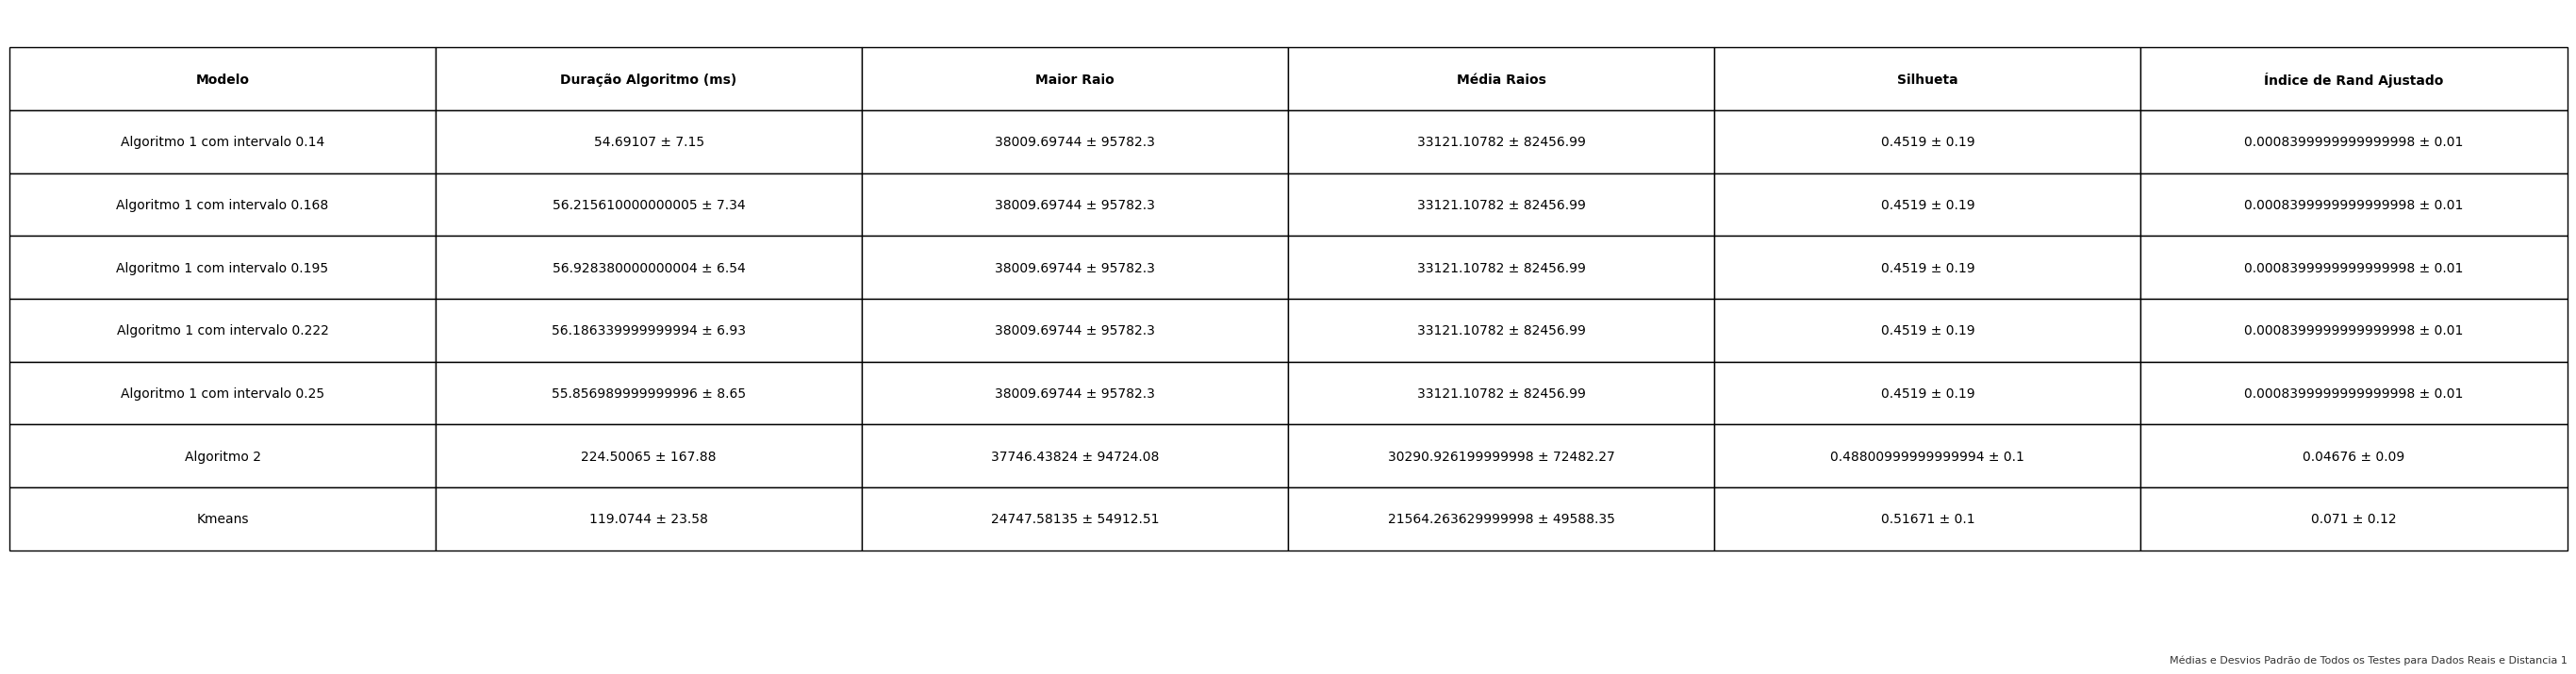

Latex da tabela:
\begin{tabular}{llllll}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 54.69107 ± 7.15 & 38009.69744 ± 95782.3 & 33121.10782 ± 82456.99 & 0.4519 ± 0.19 & 0.0008399999999999998 ± 0.01 \\
Algoritmo 1 com intervalo 0.168 & 56.215610000000005 ± 7.34 & 38009.69744 ± 95782.3 & 33121.10782 ± 82456.99 & 0.4519 ± 0.19 & 0.0008399999999999998 ± 0.01 \\
Algoritmo 1 com intervalo 0.195 & 56.928380000000004 ± 6.54 & 38009.69744 ± 95782.3 & 33121.10782 ± 82456.99 & 0.4519 ± 0.19 & 0.0008399999999999998 ± 0.01 \\
Algoritmo 1 com intervalo 0.222 & 56.186339999999994 ± 6.93 & 38009.69744 ± 95782.3 & 33121.10782 ± 82456.99 & 0.4519 ± 0.19 & 0.0008399999999999998 ± 0.01 \\
Algoritmo 1 com intervalo 0.25 & 55.856989999999996 ± 8.65 & 38009.69744 ± 95782.3 & 33121.10782 ± 82456.99 & 0.4519 ± 0.19 & 0.0008399999999999998 ± 0.01 \\
Algoritmo 2 & 224.50065 ± 167.88 & 37746.43824 ± 94724.08 &

In [43]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster,labels in zip(dada_real, names_models_real,qt_clusters_real,labels_list_real):
    labels = labels[0]
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 1, labels, nome_test, n_experimentos)
    
    print(f"Resultados para {title}")
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=names_models_real)
mean_results = combined_df.groupby("Modelo").mean().reset_index()
std_results = combined_df.groupby("Modelo").std().reset_index()

results_with_std = mean_results.copy()
for col in mean_results.columns[1:]:
    results_with_std[col] = mean_results[col].astype(str) + " ± " + std_results[col].round(2).astype(str)

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias e Desvios Padrão de Todos os Testes para Dados Reais e Distancia 1", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=results_with_std.values, colLabels=results_with_std.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = results_with_std.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Dados Reais com Distância 2

Resultados para hepatitis


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,62.6390,299944.0522,255827.7516,0.5293,-0.0001
1,Algoritmo 1 com intervalo 0.168,66.7686,299944.0522,255827.7516,0.5293,-0.0001
2,Algoritmo 1 com intervalo 0.195,71.4442,299944.0522,255827.7516,0.5293,-0.0001
3,Algoritmo 1 com intervalo 0.222,65.0637,299944.0522,255827.7516,0.5293,-0.0001
4,Algoritmo 1 com intervalo 0.25,68.0707,299944.0522,255827.7516,0.5293,-0.0001
5,Algoritmo 2,178.4938,297207.7861,221852.4000,0.5275,-0.0006
6,Kmeans,141.7370,160733.4373,150089.6358,0.5774,-0.0013


Resultados para raisin


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,57.4879,77967.0000,71968.0000,0.6431,0.0252
1,Algoritmo 1 com intervalo 0.168,57.6554,77967.0000,71968.0000,0.6431,0.0252
2,Algoritmo 1 com intervalo 0.195,59.2408,77967.0000,71968.0000,0.6431,0.0252
3,Algoritmo 1 com intervalo 0.222,60.0984,77967.0000,71968.0000,0.6431,0.0252
4,Algoritmo 1 com intervalo 0.25,56.9139,77967.0000,71968.0000,0.6431,0.0252
5,Algoritmo 2,79.0107,79171.0000,78170.5000,0.6425,0.0243
6,Kmeans,138.5870,86183.2102,65224.8731,0.6439,0.1756


Resultados para mice_protein


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,59.8174,0.8195,0.4903,0.6237,0.0017
1,Algoritmo 1 com intervalo 0.168,55.2544,0.8195,0.4903,0.6237,0.0017
2,Algoritmo 1 com intervalo 0.195,54.8909,0.8195,0.4903,0.6237,0.0017
3,Algoritmo 1 com intervalo 0.222,55.9376,0.8195,0.4903,0.6237,0.0017
4,Algoritmo 1 com intervalo 0.25,55.0621,0.8195,0.4903,0.6237,0.0017
5,Algoritmo 2,490.1884,0.3588,0.2139,0.5296,0.0764
6,Kmeans,142.1400,0.3890,0.2252,0.4470,0.1091


Resultados para yeast


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,48.8540,0.2138,0.1443,0.1883,-0.0196
1,Algoritmo 1 com intervalo 0.168,53.6399,0.2138,0.1443,0.1883,-0.0196
2,Algoritmo 1 com intervalo 0.195,52.1404,0.2138,0.1443,0.1883,-0.0196
3,Algoritmo 1 com intervalo 0.222,51.4584,0.2138,0.1443,0.1883,-0.0196
4,Algoritmo 1 com intervalo 0.25,52.1321,0.2138,0.1443,0.1883,-0.0196
5,Algoritmo 2,595.2200,0.1980,0.1670,0.1725,0.0362
6,Kmeans,137.3040,0.2697,0.1725,0.3679,0.0620


Resultados para maternal_risk


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,41.7463,20.3961,10.1980,0.8662,-0.0004
1,Algoritmo 1 com intervalo 0.168,39.2554,20.3961,10.1980,0.8662,-0.0004
2,Algoritmo 1 com intervalo 0.195,38.7300,20.3961,10.1980,0.8662,-0.0004
3,Algoritmo 1 com intervalo 0.222,41.7885,20.3961,10.1980,0.8662,-0.0004
4,Algoritmo 1 com intervalo 0.25,41.0757,20.3961,10.1980,0.8662,-0.0004
5,Algoritmo 2,69.4091,10.1980,6.7493,0.4242,0.0008
6,Kmeans,114.7730,60.2134,22.7339,0.6448,0.0192


Resultados para credit


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,53.3990,45.7930,43.2987,0.5866,0.0027
1,Algoritmo 1 com intervalo 0.168,52.3743,45.7930,43.2987,0.5866,0.0027
2,Algoritmo 1 com intervalo 0.195,56.7978,45.7930,43.2987,0.5866,0.0027
3,Algoritmo 1 com intervalo 0.222,60.8978,45.7930,43.2987,0.5866,0.0027
4,Algoritmo 1 com intervalo 0.25,56.3804,45.7930,43.2987,0.5866,0.0027
5,Algoritmo 2,47.6745,41.2311,41.0177,0.4571,0.0615
6,Kmeans,129.6360,50.6941,47.0828,0.3785,-0.0230


Resultados para adult


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,48.1774,18.2483,10.4885,0.3845,-0.0105
1,Algoritmo 1 com intervalo 0.168,49.5390,18.2483,10.4885,0.3845,-0.0105
2,Algoritmo 1 com intervalo 0.195,51.2236,18.2483,10.4885,0.3845,-0.0105
3,Algoritmo 1 com intervalo 0.222,51.4793,18.2483,10.4885,0.3845,-0.0105
4,Algoritmo 1 com intervalo 0.25,53.3509,18.2483,10.4885,0.3845,-0.0105
5,Algoritmo 2,130.0577,19.2094,13.2505,0.4490,0.0079
6,Kmeans,90.6190,25.9737,13.2506,0.4753,0.0171


Resultados para diabetic_retinopathy


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,59.0291,125.0166,116.3504,0.6244,-0.0035
1,Algoritmo 1 com intervalo 0.168,57.3940,125.0166,116.3504,0.6244,-0.0035
2,Algoritmo 1 com intervalo 0.195,61.3138,125.0166,116.3504,0.6244,-0.0035
3,Algoritmo 1 com intervalo 0.222,62.4003,125.0166,116.3504,0.6244,-0.0035
4,Algoritmo 1 com intervalo 0.25,66.6449,125.0166,116.3504,0.6244,-0.0035
5,Algoritmo 2,107.9202,155.3920,148.2071,0.6280,-0.0038
6,Kmeans,50.7570,180.5887,146.1981,0.5837,-0.0022


Resultados para dry_beans


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,66.1324,312.7150,227.3100,0.1882,0.0109
1,Algoritmo 1 com intervalo 0.168,63.8338,312.7150,227.3100,0.1882,0.0109
2,Algoritmo 1 com intervalo 0.195,60.7433,312.7150,227.3100,0.1882,0.0109
3,Algoritmo 1 com intervalo 0.222,59.6853,312.7150,227.3100,0.1882,0.0109
4,Algoritmo 1 com intervalo 0.25,71.5813,312.7150,227.3100,0.1882,0.0109
5,Algoritmo 2,346.1349,119.8320,93.8839,0.4684,0.2984
6,Kmeans,140.5500,240.6042,98.3250,0.5489,0.3510


Resultados para wine_quality


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,52.9005,0.2901,0.1500,0.4996,0.0051
1,Algoritmo 1 com intervalo 0.168,55.1579,0.2901,0.1500,0.4996,0.0051
2,Algoritmo 1 com intervalo 0.195,59.6100,0.2901,0.1500,0.4996,0.0051
3,Algoritmo 1 com intervalo 0.222,58.6000,0.2901,0.1500,0.4996,0.0051
4,Algoritmo 1 com intervalo 0.25,58.3955,0.2901,0.1500,0.4996,0.0051
5,Algoritmo 2,329.8258,0.1202,0.0934,0.4675,0.0069
6,Kmeans,33.4300,0.4332,0.1393,0.4997,0.0025


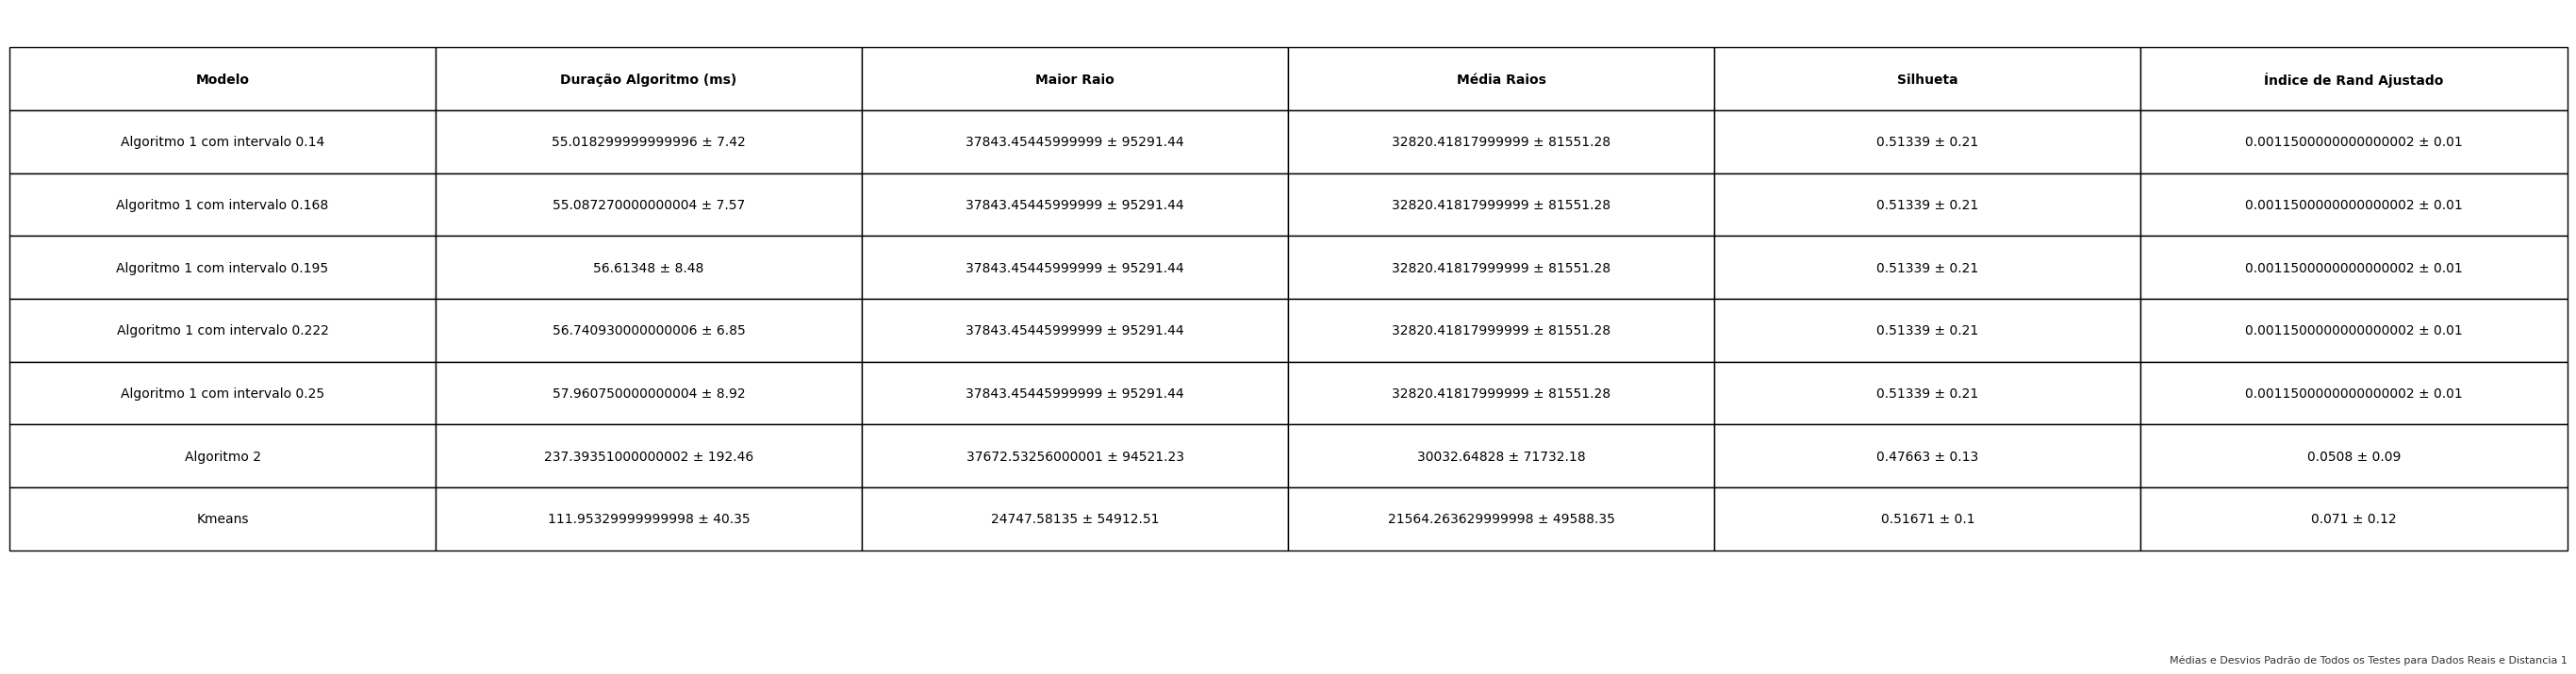

Latex da tabela:
\begin{tabular}{llllll}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 55.018299999999996 ± 7.42 & 37843.45445999999 ± 95291.44 & 32820.41817999999 ± 81551.28 & 0.51339 ± 0.21 & 0.0011500000000000002 ± 0.01 \\
Algoritmo 1 com intervalo 0.168 & 55.087270000000004 ± 7.57 & 37843.45445999999 ± 95291.44 & 32820.41817999999 ± 81551.28 & 0.51339 ± 0.21 & 0.0011500000000000002 ± 0.01 \\
Algoritmo 1 com intervalo 0.195 & 56.61348 ± 8.48 & 37843.45445999999 ± 95291.44 & 32820.41817999999 ± 81551.28 & 0.51339 ± 0.21 & 0.0011500000000000002 ± 0.01 \\
Algoritmo 1 com intervalo 0.222 & 56.740930000000006 ± 6.85 & 37843.45445999999 ± 95291.44 & 32820.41817999999 ± 81551.28 & 0.51339 ± 0.21 & 0.0011500000000000002 ± 0.01 \\
Algoritmo 1 com intervalo 0.25 & 57.960750000000004 ± 8.92 & 37843.45445999999 ± 95291.44 & 32820.41817999999 ± 81551.28 & 0.51339 ± 0.21 & 0.0011500000000000002

In [44]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster,labels in zip(dada_real, names_models_real,qt_clusters_real,labels_list_real):
    labels = labels[0]
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 2, labels, nome_test, n_experimentos)
    
    print(f"Resultados para {title}")
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=names_models_real)
mean_results = combined_df.groupby("Modelo").mean().reset_index()
std_results = combined_df.groupby("Modelo").std().reset_index()

results_with_std = mean_results.copy()
for col in mean_results.columns[1:]:
    results_with_std[col] = mean_results[col].astype(str) + " ± " + std_results[col].round(2).astype(str)

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias e Desvios Padrão de Todos os Testes para Dados Reais e Distancia 1", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=results_with_std.values, colLabels=results_with_std.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = results_with_std.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)